<a href="https://colab.research.google.com/github/mylibui/demo/blob/master/AE_VAE_Modelle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import datetime
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import os
import pandas as pd
from typing import Union, Tuple, Optional, List, Any,Dict

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path= '/content/drive/MyDrive/Data/creditcard.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [5]:
# Normalize the 'Amount' column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Drop the 'Time' column as it is not useful for anomaly detection
df = df.drop(['Time'], axis=1)

In [6]:
# Separate features and labels
X = df.drop(['Class'], axis=1).values
y = df['Class'].values


In [7]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Only use normal transactions for training (Class = 0)
X_train_normal = X_train[y_train == 0]

In [8]:
# Hyperparameters
input_dim = X_train.shape[1]
latent_dim = 16
hidden_dims = [64, 32]  # Two hidden layers with 64 and 32 neurons respectively
epochs = 20
batch_size = 256

#0. Hilffunktion definiern

## 1.Plot Verlustkurve

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Union, Optional, Tuple, List, Dict

def plot_loss_curves(
    history: Union[tf.keras.callbacks.History, Dict],
    model_type: str,  # Standardwert auf 'uae' gesetzt für Flexibilität
    figsize: Tuple[int, int] = (16, 10),
    save_path: Optional[str] = None,
    folder_name: str = "vae_results/loss_curves"
) -> Tuple[plt.Figure, List[plt.Axes]]:
    """
    Plottet umfassende Loss-Kurven für verschiedene Autoencoder-Modelltypen (UnsupervisedAE, UnsupervisedVAE,
    SupervisedAE, SupervisedVAE) und speichert sie optional in einem Google Drive-Ordner.

    Args:
        history: Das History-Objekt aus dem `model.fit()`-Aufruf oder ein Dictionary mit Metriken.
        model_type: Typ des Modells ('uae', 'uvae', 'sae', 'svae'). Standardwert ist 'uae'.
        figsize: Größe der Abbildung als Tuple (Breite, Höhe). Standardwert ist (16, 10).
        save_path: Optionaler Pfad, um das Plot zu speichern (Standardwert ist None). Wenn None, wird der Pfad aus folder_name generiert.
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem das Plot gespeichert werden soll (Standardwert ist "vae_results/loss_curves").

    Returns:
        Tuple[plt.Figure, List[plt.Axes]]: Figure- und Axes-Objekte für weitere Anpassungen.

    Raises:
        ValueError: Wenn `history` kein gültiges History-Objekt oder Dictionary ist, `model_type` unbekannt ist, oder keine gültigen Metriken vorhanden sind.
        TypeError: Wenn `figsize` kein Tuple oder `history` kein Dict/History-Objekt ist.
    """
    # Eingabevalidierung
    if not isinstance(history, (tf.keras.callbacks.History, dict)):
        raise TypeError("history muss ein tf.keras.callbacks.History-Objekt oder Dictionary sein")
    if not isinstance(figsize, tuple) or len(figsize) != 2 or not all(isinstance(d, int) and d > 0 for d in figsize):
        raise TypeError("figsize muss ein Tuple von zwei positiven Ganzzahlen sein")
    valid_model_types = {'uae', 'uvae', 'sae', 'svae'}
    if model_type not in valid_model_types:
        raise ValueError(f"model_type muss einer von {valid_model_types} sein, nicht {model_type}")

    # Extrahiere Metriken aus History oder Dictionary
    metrics = list(history.history.keys() if isinstance(history, tf.keras.callbacks.History) else history.keys())
    if not metrics:
        raise ValueError("Keine Metriken in history vorhanden")

    # Bestimme relevante Loss-Metriken basierend auf dem Modelltyp
    loss_metrics = [m for m in metrics if 'loss' in m.lower() and 'val' not in m]
    val_metrics_exist = any('val_' in m for m in metrics)

    # Konfiguriere die Anzahl der Subplots basierend auf dem Modelltyp
    if model_type in ['uae', 'uvae']:
        expected_losses = ['loss', 'reconstruction_loss']
        if model_type == 'uvae':
            expected_losses.append('kl_loss')
        n_plots = min(3, len([m for m in loss_metrics if m in expected_losses]))
    else:  # 'sae', 'svae'
        expected_losses = ['loss', 'reconstruction_loss', 'classification_loss']
        if model_type == 'svae':
            expected_losses.append('kl_loss')
        n_plots = min(4, len([m for m in loss_metrics if m in expected_losses]))

    # Erstelle Figure und Axes
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]  # Für Konsistenz bei einem einzigen Plot

    # Farben und Stil für die Plots
    colors = {
        'loss': 'blue',
        'reconstruction_loss': 'green',
        'kl_loss': 'cyan',
        'classification_loss': 'orange'
    }
    line_styles = {'training': '-', 'validation': '--'}

    # Plot-Index
    ax_idx = 0

    # Plot 1: Gesamtverlust (falls vorhanden, ansonsten überspringen)
    if 'loss' in metrics:
        ax = axes[ax_idx]
        ax.plot(history.history['loss'], color=colors['loss'], linestyle=line_styles['training'],
                linewidth=2, label='Training')
        if val_metrics_exist and 'val_loss' in metrics:
            ax.plot(history.history['val_loss'], color=colors['loss'], linestyle=line_styles['validation'],
                    linewidth=2, label='Validierung')

        ax.set_title('Gesamtverlust', fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)

        # Annotations für Start- und Endwerte
        start_val = history.history['loss'][0]
        end_val = history.history['loss'][-1]
        ax.annotate(f'Start: {start_val:.4f}', xy=(0, start_val), xytext=(5, 10),
                    textcoords='offset points', color=colors['loss'], fontsize=10)
        ax.annotate(f'End: {end_val:.4f}', xy=(len(history.history['loss'])-1, end_val),
                   xytext=(5, -15), textcoords='offset points', color=colors['loss'], fontsize=10)

        if val_metrics_exist and 'val_loss' in metrics:
            val_start = history.history['val_loss'][0]
            val_end = history.history['val_loss'][-1]
            ax.annotate(f'Start: {val_start:.4f}', xy=(0, val_start), xytext=(5, -30),
                        textcoords='offset points', color=colors['loss'], fontsize=10)
            ax.annotate(f'End: {val_end:.4f}', xy=(len(history.history['val_loss'])-1, val_end),
                       xytext=(5, -45), textcoords='offset points', color=colors['loss'], fontsize=10)

        ax_idx += 1
    else:
        print("Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.")

    # Plot 2: Rekonstruktionsverlust
    if 'reconstruction_loss' in metrics and ax_idx < n_plots:
        ax = axes[ax_idx]
        ax.plot(history.history['reconstruction_loss'], color=colors['reconstruction_loss'], linestyle=line_styles['training'],
                linewidth=2, label='Training')
        if val_metrics_exist and 'val_reconstruction_loss' in metrics:
            ax.plot(history.history['val_reconstruction_loss'], color=colors['reconstruction_loss'], linestyle=line_styles['validation'],
                    linewidth=2, label='Validierung')

        ax.set_title('Rekonstruktionsverlust', fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)

        # Annotations für Endwerte
        end_val = history.history['reconstruction_loss'][-1]
        ax.annotate(f'End: {end_val:.4f}', xy=(len(history.history['reconstruction_loss'])-1, end_val),
                   xytext=(5, 10), textcoords='offset points', color=colors['reconstruction_loss'], fontsize=10)

        if val_metrics_exist and 'val_reconstruction_loss' in metrics:
            val_end = history.history['val_reconstruction_loss'][-1]
            ax.annotate(f'End: {val_end:.4f}', xy=(len(history.history['reconstruction_loss'])-1, val_end),
                       xytext=(5, -15), textcoords='offset points', color=colors['reconstruction_loss'], fontsize=10)

        ax_idx += 1

    # Plot 3: KL-Divergenz (nur für UnsupervisedVAE und SupervisedVAE)
    if 'kl_loss' in metrics and ax_idx < n_plots and model_type in ['uvae', 'svae']:
        ax = axes[ax_idx]
        ax.plot(history.history['kl_loss'], color=colors['kl_loss'], linestyle=line_styles['training'],
                linewidth=2, label='Training')
        if val_metrics_exist and 'val_kl_loss' in metrics:
            ax.plot(history.history['val_kl_loss'], color=colors['kl_loss'], linestyle=line_styles['validation'],
                    linewidth=2, label='Validierung')

        ax.set_title('KL-Divergenz', fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)

        # Annotations für Endwerte
        end_val = history.history['kl_loss'][-1]
        ax.annotate(f'End: {end_val:.4f}', xy=(len(history.history['kl_loss'])-1, end_val),
                   xytext=(5, 10), textcoords='offset points', color=colors['kl_loss'], fontsize=10)

        if val_metrics_exist and 'val_kl_loss' in metrics:
            val_end = history.history['val_kl_loss'][-1]
            ax.annotate(f'End: {val_end:.4f}', xy=(len(history.history['kl_loss'])-1, val_end),
                       xytext=(5, -15), textcoords='offset points', color=colors['kl_loss'], fontsize=10)

        ax_idx += 1

    # Plot 4: Klassifikationsverlust (nur für SupervisedAE und SupervisedVAE)
    if 'classification_loss' in metrics and ax_idx < n_plots and model_type in ['sae', 'svae']:
        ax = axes[ax_idx]
        ax.plot(history.history['classification_loss'], color=colors['classification_loss'], linestyle=line_styles['training'],
                linewidth=2, label='Training')
        if val_metrics_exist and 'val_classification_loss' in metrics:
            ax.plot(history.history['val_classification_loss'], color=colors['classification_loss'], linestyle=line_styles['validation'],
                    linewidth=2, label='Validierung')

        ax.set_title('Klassifikationsverlust', fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss', fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(alpha=0.3)

        # Annotations für Endwerte
        end_val = history.history['classification_loss'][-1]
        ax.annotate(f'End: {end_val:.4f}', xy=(len(history.history['classification_loss'])-1, end_val),
                   xytext=(5, 10), textcoords='offset points', color=colors['classification_loss'], fontsize=10)

        if val_metrics_exist and 'val_classification_loss' in metrics:
            val_end = history.history['val_classification_loss'][-1]
            ax.annotate(f'End: {val_end:.4f}', xy=(len(history.history['classification_loss'])-1, val_end),
                       xytext=(5, -15), textcoords='offset points', color=colors['classification_loss'], fontsize=10)

        ax_idx += 1

    # Gesamttitel
    plt.suptitle(f'Trainingsverlauf - {model_type.upper()} Modell', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Platz für den Suptitle

    # Speichern des Plots in einem Google Drive-Ordner
    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Generiere einen eindeutigen Dateinamen basierend auf dem Modelltyp
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(folder_path, f"loss_curves_{model_type}_{timestamp}.png")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Loss-Kurven wurden gespeichert unter: {save_path}")
        #plt.close()  # Speicherfreigabe in Google Colab

    return fig, axes

## 2.Rekonstruktiomfehler berechnen

In [10]:
def calculate_reconstruction_error(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE'
                 , 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray
) -> np.ndarray:
    """
    Berechnet den Rekonstruktionsfehler (MSE) für ein Modell.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).

    Returns:
        np.ndarray: Array mit MSE-Werten pro Sample.

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat oder X ungültig ist.
        TypeError: Wenn X kein NumPy-Array oder Tensor ist.
    """
    # Rekonstruktion basierend auf Modelltyp
    if isinstance(model, UnsupervisedAE):
        reconstructed = model(X, training=False)  # Nur rekonstruierte Daten für UnsupervisedAE
    elif isinstance(model, UnsupervisedVAE):
        reconstructed, _, _ = model(X, training=False)  # Ignoriere z_mean und z_log_var, nehme nur rekonstruiert
    elif isinstance(model, SupervisedAE):
        reconstructed, _ = model(X, training=False)  # Ignoriere Klassifikationsausgabe
    elif isinstance(model, SupervisedVAE):
        reconstructed, _, _, _ = model(X, training=False)  # Ignoriere z_mean, z_log_var und Klassifikation

    # Berechnung des MSE pro Sample
    reconstruction_error = tf.reduce_mean(tf.square(X - reconstructed), axis=-1)

    # Konvertierung zu NumPy-Array für einfache Handhabung
    return reconstruction_error.numpy()

plot rekonstruktion fehler

##3.Plot Rekonstruktion fehler hist & boxplot

In [11]:
import os
from typing import Union, Optional
def plot_reconstruction_analysis(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE', 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    threshold: Optional[float] = None,
    save_path: Optional[str] = None,
    folder_name: str = "vae_results/reconstruction_analysis"
) -> None:
    """
    Plottet einen Boxplot und die Verteilung (Histogramm mit Dichte) des Rekonstruktionsfehlers für Fraud und Nicht Fraud in einem Google Drive-Ordner.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        threshold: Optionaler Schwellenwert für Anomaliedetektion (Standardwert ist None, dann wird find_optimal_threshold verwendet).
        save_path: Optionaler Pfad, um das Plot zu speichern (Standardwert ist None). Wenn None, wird der Pfad aus folder_name generiert.
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem das Plot gespeichert werden soll (Standardwert ist "vae_results/reconstruction_analysis").

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """
    # Berechne Rekonstruktionsfehler
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Bestimme optimalen Schwellenwert, falls keiner angegeben ist
    threshold, _ = find_optimal_threshold(model, X, y)

    # Trennen von Fraud und Nicht Fraud Daten
    not_fraud_error = reconstruction_error[y == 0]
    fraud_error = reconstruction_error[y == 1]

    # Kombinierte Daten für Boxplot und Histogramm
    data = np.concatenate([not_fraud_error, fraud_error])
    labels = np.concatenate([np.repeat('Nicht Fraud', len(not_fraud_error)), np.repeat('Fraud', len(fraud_error))])

    # Speichern des Plots in einem Google Drive-Ordner
    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Generiere einen eindeutigen Dateinamen
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(folder_path, f"reconstruction_analysis_{timestamp}.png")

    # Erstellen des Plots
    plt.figure(figsize=(12, 8))

    # Boxplot (oben)
    plt.subplot(2, 1, 1)
    sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})
    plt.title("Boxplot des Rekonstruktionsfehlers: Fraud vs. Nicht Fraud")
    plt.xlabel("")
    plt.ylabel("Rekonstruktionsfehler (MSE)")
    plt.axhline(y=threshold, color='black', linestyle='--', label=f'Optimaler Schwellenwert = {threshold:.4f}')
    plt.legend()

    # Histogramm mit Dichte (unten)
    plt.subplot(2, 1, 2)
    sns.histplot(data=not_fraud_error, bins=50, color='blue', label='Nicht Fraud', alpha=0.5, stat='density')
    sns.histplot(data=fraud_error, bins=50, color='red', label='Fraud', alpha=0.5, stat='density')

    plt.axvline(x=threshold, color='black', linestyle='--', label=f'Optimaler Schwellenwert = {threshold:.4f}')
    plt.title("Verteilung des Rekonstruktionsfehlers (Dichte): Fraud vs. Nicht Fraud")
    plt.xlabel("Rekonstruktionsfehler (MSE)")
    plt.ylabel("Dichte")
    plt.legend()

    plt.tight_layout()

    # Speichern des Plots
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.close()  # Speicherfreigabe in Google Colab

    print(f"Analyse wurde gespeichert unter: {save_path}")

## 4.Optimal Threshold finden

In [12]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score
from typing import Union, Optional
def find_optimal_threshold(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE'
                 , 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    thresholds: Optional[np.ndarray] = None
) -> Tuple[float, float]:
    """
    Bestimmt den optimalen Schwellenwert für die Anomaliedetektion basierend auf dem F1-Score.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        thresholds: Optionaler Array mit Schwellenwerten zum Testen (Standardwert ist None, dann wird ein Bereich von 0.1 bis 5.0 mit 100 Schritten verwendet).

    Returns:
        Tuple[float, float]: (optimaler Schwellenwert, maximaler F1-Score).

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """

    # Konvertiere X zu Tensor, falls es ein NumPy-Array ist
    x = tf.convert_to_tensor(X, dtype=tf.float32)

    # Berechne Rekonstruktionsfehler
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Standard-Schwellenwerte, falls keine angegeben sind
    if thresholds is None:
        # Wähle Schwellenwerte basierend auf den tatsächlichen Rekonstruktionsfehlern
        min_error = np.min(reconstruction_error)
        max_error = np.max(reconstruction_error)
        thresholds = np.linspace(min_error, max_error, 100)

    # Rest der Funktion bleibt gleich
    best_f1 = 0.0
    best_threshold = 0.0

    for th in thresholds:
        y_pred = (reconstruction_error > th).astype(int)
        f1 = f1_score(y, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = th

    return best_threshold, best_f1

## 5.Fraud Prediction definieren

In [13]:
def detect_fraud(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE'
                 , 'SupervisedAE'
                 ,'SupervisedVAE'
                 ],
    X: np.ndarray,
    threshold: Optional[float] = None
) -> np.ndarray:
    """
    Detektiert Fraud-Transaktionen basierend auf dem Rekonstruktionsfehler und einem Schwellenwert.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        threshold: Optionaler Schwellenwert für Anomaliedetektion (Standardwert ist None, dann wird find_optimal_threshold verwendet).

    Returns:
        np.ndarray: Array mit Vorhersagen (0 für Nicht Fraud, 1 für Fraud).

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat oder X ungültig ist.
        TypeError: Wenn X kein NumPy-Array oder Tensor ist.
    """

    # Berechne Rekonstruktionsfehler
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Bestimme optimalen Schwellenwert, falls keiner angegeben ist
    if threshold is None:
        # Hier simulieren wir, dass wir Labels haben (z. B. aus Testdaten)
        # In der Praxis müssen Sie y_test bereitstellen
        # Für dieses Beispiel nehmen wir an, dass wir keine Labels haben und einen Standard-Schwellenwert verwenden
        threshold, _ = find_optimal_threshold(model, X, np.zeros(len(X)))  # Dummy-Labels für Demo
        print(f"Optimaler Schwellenwert (ohne echte Labels): {threshold}")

    # Detektiere Fraud basierend auf Schwellenwert
    fraud_predictions = (reconstruction_error > threshold).astype(int)

    return fraud_predictions

## 6.Evaluate Fraud Detection definieren

In [14]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from typing import Union, Optional,Dict

def evaluate_fraud_detection(
    model: Union['UnsupervisedAE'
                 ,'UnsupervisedVAE'
                 , 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    threshold: Optional[float] = None,
    save_metrics: bool = False,
    folder_name: str = "vae_results/metrics"
) -> Dict[str, float]:
    """
    Evaluert die Fraud-Detektion, berechnet Metriken und gibt einen Klassifikationsbericht aus.

    Args:
        model: Das Modell, für das der Rekonstruktionsfehler berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        threshold: Optionaler Schwellenwert für Anomaliedetektion (Standardwert ist None, dann wird find_optimal_threshold verwendet).
        save_metrics: Boolean, ob die Metriken in einer Textdatei in Google Drive gespeichert werden sollen (Standardwert ist False).
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem die Metriken gespeichert werden sollen (Standardwert ist "vae_results/metrics").

    Returns:
        Dict[str, float]: Dictionary mit Metriken (Precision, Recall, F1-Score, Accuracy, ROC-AUC).

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """
        # Bestimme optimalen Schwellenwert, falls keiner angegeben ist
    if threshold is None:
        threshold, _ = find_optimal_threshold(model, X, y)
        print(f"Optimaler Schwellenwert basierend auf F1-Score: {threshold}")

    # Detektiere Fraud
    fraud_predictions = detect_fraud(model, X, threshold)

    # Berechne Metriken
    precision = precision_score(y, fraud_predictions)
    recall = recall_score(y, fraud_predictions)
    f1 = f1_score(y, fraud_predictions)
    accuracy = accuracy_score(y, fraud_predictions)

    # Berechne ROC-AUC (benötigt Wahrscheinlichkeiten, daher verwenden wir Rekonstruktionsfehler als Score)
    roc_auc = roc_auc_score(y,fraud_predictions)  # Negieren, da niedrigere Rekonstruktionsfehler normal sind

    # Erstelle Klassifikationsbericht
    print("\nKlassifikationsbericht:")
    print(classification_report(y, fraud_predictions, target_names=['Nicht Fraud', 'Fraud']))

    # Gib Metriken aus
    metrics_dict = {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc
    }
    print("\nMetriken:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")

    # Speichere Metriken in Google Drive, falls gewünscht
    if save_metrics:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Generiere einen eindeutigen Dateinamen
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        metrics_path = os.path.join(folder_path, f"metrics_{timestamp}.txt")

        with open(metrics_path, 'w') as f:
            f.write("Klassifikationsbericht:\n")
            f.write(classification_report(y, fraud_predictions, target_names=['Nicht Fraud', 'Fraud']))
            f.write("\nMetriken:\n")
            for metric, value in metrics_dict.items():
                f.write(f"{metric}: {value:.4f}\n")

        print(f"Metriken wurden gespeichert unter: {metrics_path}")

    return metrics_dict

## 7.Plot ROC_AUC curve

In [15]:
def plot_roc_auc_curve(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE', 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    threshold: Optional[float] = None,
    save_path: Optional[str] = None,
    folder_name: str = "vae_results/roc_curves"
) -> None:
    """
    Plottet die ROC-AUC-Kurve für ein Modell und speichert das Plot optional in einem Google Drive-Ordner.

    Args:
        model: Das Modell, für das die ROC-Kurve berechnet werden soll (UnsupervisedAE, UnsupervisedVAE, SupervisedAE, oder SupervisedVAE).
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        threshold: Optionaler Schwellenwert für Anomaliedetektion (Standardwert ist None, dann wird find_optimal_threshold verwendet).
        save_path: Optionaler Pfad, um das Plot zu speichern (Standardwert ist None). Wenn None, wird der Pfad aus folder_name generiert.
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem das Plot gespeichert werden soll (Standardwert ist "vae_results/roc_curves").

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """

    # Berechne Rekonstruktionsfehler
    reconstruction_error = calculate_reconstruction_error(model, X)

    # Bestimme optimalen Schwellenwert, falls keiner angegeben ist
    threshold, _ = find_optimal_threshold(model, X, y)
    print(f"Optimaler Schwellenwert basierend auf F1-Score: {threshold}")
    # Extrahiere den Modellnamen
    model_name = model.__class__.__name__  # z. B. "UnsupervisedAE"
    # Berechne ROC-Kurve und AUC
    fpr, tpr, thresholds_roc = roc_curve(y,reconstruction_error)  # Negieren, da niedrigere Rekonstruktionsfehler normal sind
    roc_auc = auc(fpr, tpr)

    # Speichern des Plots in einem Google Drive-Ordner
    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Generiere einen eindeutigen Dateinamen
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(folder_path, f"{model_name}roc_curve_{timestamp}.png")

    # Erstellen des Plots
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Zufallsprognose')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC-Kurve für Fraud-Detektion')
    plt.legend(loc="lower right")

    # Speichern des Plots
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.close()  # Speicherfreigabe in Google Colab

    print(f"ROC-Kurve wurde gespeichert unter: {save_path}")
    print(f"ROC-AUC: {roc_auc:.4f}")

## 8.Plot laten Space

In [16]:
def plot_latent_space(
    model: Union['UnsupervisedAE'
                 , 'UnsupervisedVAE', 'SupervisedAE'
                 , 'SupervisedVAE'
                 ],
    X: np.ndarray,
    y: np.ndarray,
    save_path: Optional[str] = None,
    folder_name: str = "vae_results/latent_space"
) -> None:
    """
    Plottet den latenten Raum eines SupervisedAE-Modells als 2D-Scatterplot und speichert das Plot als PNG in einem Google Drive-Ordner.

    Args:
        model: Das SupervisedAE-Modell, dessen latenter Raum visualisiert werden soll.
        X: Eingabedaten als NumPy-Array oder Tensor der Form (Batch-Größe, input_dim).
        y: Labels als NumPy-Array (0 für Nicht Fraud, 1 für Fraud).
        save_path: Optionaler Pfad, um das Plot zu speichern (Standardwert ist None). Wenn None, wird der Pfad aus folder_name generiert.
        folder_name: Name des Ordners (relativ zu /content/drive/MyDrive/), in dem das Plot gespeichert werden soll (Standardwert ist "vae_results/latent_space").

    Raises:
        ValueError: Wenn das Modell einen unbekannten Typ hat, X oder y ungültig sind.
        TypeError: Wenn X oder y kein NumPy-Array oder Tensor ist.
    """

    # Konvertiere X zu Tensor, falls es ein NumPy-Array ist
    x = tf.convert_to_tensor(X, dtype=tf.float32)

    # Extrahiere den latenten Raum mit der encode-Methode
    # The original line was trying to call .numpy() on a tuple, which is not possible.
    # Assuming your encode method returns a tuple where the first element is the latent representation,
    # we need to access that element.
# Extrahiere den latenten Raum basierend auf dem Modelltyp
    if isinstance(model, UnsupervisedAE):
        latent_representation = model.encode(x).numpy()  # Direkte latente Darstellung
    elif isinstance(model, UnsupervisedVAE):
        z_mean, _, _ = model.encode(x)  # Nimm z_mean als latente Darstellung
        latent_representation = z_mean.numpy()
    elif isinstance(model, SupervisedAE):
        latent_representation = model.encode(x).numpy()  # Direkte latente Darstellung
    elif isinstance(model, SupervisedVAE):
        z_mean, _, _ = model.encode(x)  # Nimm z_mean als latente Darstellung
        latent_representation = z_mean.numpy()
    else:
        raise ValueError("Unbekannter Modelltyp – sollte nicht auftreten aufgrund vorheriger Validierung")

    # Reduziere die Dimensionen auf 2, falls latent_dim > 2
    if latent_representation.shape[1] > 2:
        pca = PCA(n_components=2)
        latent_2d = pca.fit_transform(latent_representation)
    else:
        latent_2d = latent_representation  # Verwende direkt die ersten zwei Dimensionen, wenn latent_dim <= 2

    # Speichern des Plots in einem Google Drive-Ordner
    if save_path is None:
        # Basisverzeichnis für Google Drive
        base_dir = "/content/drive/MyDrive"
        folder_path = os.path.join(base_dir, folder_name)

        # Erstelle den Ordner, falls er nicht existiert
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

     # Generiere einen eindeutigen Dateinamen basierend auf dem Modelltyp
        model_name = model.__class__.__name__
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        save_path = os.path.join(folder_path, f"latent_space_{model_name}_{timestamp}.png")

    # Erstellen des Plots
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y, cmap='bwr', alpha=0.5)
    plt.colorbar(scatter, label='Klasse (0 = Nicht Fraud, 1 = Fraud)')
    plt.title(f"Latenter Raum des {model_name}-Modells")
    plt.xlabel("Latente Dimension 1")
    plt.ylabel("Latente Dimension 2")

    # Speichern des Plots
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #plt.close()  # Speicherfreigabe in Google Colab

    print(f"Latenter Raum wurde gespeichert unter: {save_path}")

## 9.HyperParameter definieren

In [17]:
epoch=30
learning_rate=0.001
latent_dim=16
hidden_dims=[64,32]
dropout_rate=0.1
activation='mish'
batch_size=256
kl_weight=1
classifier_dim=[16]

#I. Unsupervised Autoencoder (AE)


---



## 1.Klasse AE definieren

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from typing import List, Optional, Union, Tuple

class UnsupervisedAE(Model):
    """
    Unüberwachter Autoencoder für Anomalieerkennung mit anpassbarer latenter Dimension.

    Args:
        input_dim (int): Dimension der Eingabedaten.
        hidden_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Encoder/Decoder (Standard: [64, 32]).
        latent_dim (int): Dimension des latenten Raums (anpassbar, Standard: 32).
        activation (str, optional): Aktivierungsfunktion ('relu', 'mish', 'swish'). Standardwert ist 'relu'.
        dropout_rate (float, optional): Dropout-Rate zwischen 0 und 1. Standardwert ist 0.0.
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [64, 32],
        latent_dim: int = 16,
        activation: str = 'relu',
        dropout_rate: float = 0.0
    ):
        super(UnsupervisedAE, self).__init__()

        # Eingabevalidierung
        if not isinstance(input_dim, int) or input_dim <= 0:
            raise ValueError("input_dim muss eine positive Ganzzahl sein")
        if not isinstance(hidden_dims, (list, tuple)) or not all(isinstance(d, int) and d > 0 for d in hidden_dims):
            raise ValueError("hidden_dims muss eine Liste positiver Ganzzahlen sein")
        if not isinstance(latent_dim, int) or latent_dim <= 0:
            raise ValueError("latent_dim muss eine positive Ganzzahl sein")
        if dropout_rate < 0 or dropout_rate >= 1:
            raise ValueError("dropout_rate muss zwischen 0 und 1 liegen")
        if activation not in ['relu', 'mish', 'swish']:
            raise ValueError("activation muss 'relu', 'mish' oder 'swish' sein")

        # Aktivierungsfunktion direkt definieren
        if activation == 'mish':
            self.activation = lambda x: x * tf.math.tanh(tf.math.softplus(x))
        elif activation == 'swish':
            self.activation = lambda x: x * tf.nn.sigmoid(x)
        elif activation == 'relu':
            self.activation = 'relu'
        else:
            raise ValueError(f"Unbekannte Aktivierungsfunktion: {activation}")

        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate

        # Encoder-Schichten mit optionalem Dropout
        self.encoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation)
            for dim in hidden_dims
        ]
        if dropout_rate > 0:
            self.encoder_dropout = layers.Dropout(dropout_rate)

        # Latente Schicht im Encoder
        self.latent_layer = layers.Dense(latent_dim, activation=None)  # Keine Aktivierung für latenten Raum

        # Decoder-Schichten mit optionalem Dropout
        self.decoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation)
            for dim in reversed(hidden_dims)
        ]
        if dropout_rate > 0:
            self.decoder_dropout = layers.Dropout(dropout_rate)

        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')

        # Metriken
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")

    @property
    def metrics(self) -> List[metrics.Metric]:
        """Gibt die Liste der Metriken zurück."""
        return [self.reconstruction_loss_tracker]

    def encode(self, x: tf.Tensor) -> tf.Tensor:
        """
        Kodierung der Eingabedaten in den latenten Raum.

        Args:
            x: Eingabetensor der Form (Batch-Größe, input_dim).

        Returns:
            Latenter Tensor der Form (Batch-Größe, latent_dim).
        """
        for layer in self.encoder_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.encoder_dropout(x, training=True)
        return self.latent_layer(x)

    def decode(self, z: tf.Tensor) -> tf.Tensor:
        """
        Dekodierung der latenten Variablen in rekonstruierte Daten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim).

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim).
        """
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
            if self.dropout_rate > 0 and layer != self.decoder_layers[-1]:  # Kein Dropout in der letzten Schicht
                x = self.decoder_dropout(x, training=True)
        return self.decoder_output(x)

    def call(self, inputs: tf.Tensor, training: bool = False) -> tf.Tensor:
        """
        Vorwärtspass durch den Autoencoder.

        Args:
            inputs: Eingabetensor der Form (Batch-Größe, input_dim).
            training: Boolean, der angibt, ob Trainings- oder Inferenzmodus vorliegt.

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim).
        """
        encoded = self.encode(inputs)
        reconstructed = self.decode(encoded)
        return reconstructed

    def train_step(self, data: Union[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]) -> Dict[str, float]:
        """
        Trainings-Schritt für den Autoencoder mit MSE-Verlust.

        Args:
            data: Eingabetensor der Trainingsdaten oder Tuple (x, y) für TensorFlow 2.18.

        Returns:
            Dictionary mit Metrikwerten.
        """
        if isinstance(data, tuple):
            if len(data) == 2:
                x, _ = data  # Ignoriere y, da es unüberwacht ist
            else:
                x = data[0]
        else:
            x = data

        with tf.GradientTape() as tape:
            reconstruction = self.call(x, training=True)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=-1))

        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)

        return {"reconstruction_loss": self.reconstruction_loss_tracker.result()}

    def test_step(self, data: Union[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]) -> Dict[str, float]:
        """
        Test-Schritt für den Autoencoder mit MSE-Verlust.

        Args:
            data: Eingabetensor der Testdaten oder Tuple (x, y) für TensorFlow 2.18.

        Returns:
            Dictionary mit Metrikwerten.
        """
        if isinstance(data, tuple):
            if len(data) == 2:
                x, _ = data  # Ignoriere y, da es unüberwacht ist
            else:
                x = data[0]
        else:
            x = data

        reconstruction = self.call(x, training=False)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=-1))

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)

        return {"reconstruction_loss": self.reconstruction_loss_tracker.result()}

    def print_summary(self):
        """
        Gibt eine Zusammenfassung der Modellarchitektur aus.

        Diese Methode verwendet die `summary()`-Methode von TensorFlow/Keras, um die Layer, Parameter und Ausgabetypen anzuzeigen.
        """
        self.summary()

    def build(self, input_shape: Tuple[int, int]) -> None:
        """
        Baut das Modell explizit mit der angegebenen Eingabeform.

        Args:
            input_shape: Tuple der Form (Batch-Größe, input_dim), wobei Batch-Größe optional ist.

        Raises:
            ValueError: Wenn input_shape kein gültiges Tuple ist.
        """
        if isinstance(input_shape, tuple) and len(input_shape) >= 1:
            input_dim = input_shape[-1]  # Nehme die letzte Dimension als input_dim
        else:
            raise ValueError("input_shape muss ein Tuple sein, z. B. (None, input_dim)")

        # Erstelle ein Dummy-Input-Tensor, um das Modell zu bauen
        dummy_input = tf.zeros((1, input_dim), dtype=tf.float32)
        self.call(dummy_input, training=False)  # Baut das Modell, indem es auf Dummy-Daten angewendet wird

## 2.Trainiern AE

In [41]:
# Erstellen und Trainieren des Autoencoders mit anpassbaren Parametern
uae = UnsupervisedAE(
    input_dim=X_train_normal.shape[1],
    hidden_dims=[64, 32],  # Standardmäßig [64, 32], aber anpassbar
    latent_dim=16,  # Anpassbar
    activation='mish',  # Anpassbar
    dropout_rate=0.1  # Anpassbar
)

In [42]:
# Konfigurieren des Optimierers
uae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

# Training des Autoencoders
history = uae.fit(
    X_train_normal,
    epochs=epoch,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0
)

In [43]:
def save_model_to_drive(self, folder_path: str = "vae_results/models") -> None:
    """
    Speichert das Modell und seine Gewichte in einem Google Drive-Ordner.

    Args:
        folder_path: Pfad im Google Drive, in dem das Modell gespeichert werden soll (relativ zu /content/drive/MyDrive/). Standardwert ist "vae_results/models".
    """
    import os
    import datetime

    # Basisverzeichnis für Google Drive
    base_dir = "/content/drive/MyDrive"
    full_path = os.path.join(base_dir, folder_path)

    # Erstelle den Ordner, falls er nicht existiert
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    # Speichere das Modell
    model_path = os.path.join(full_path, f"uae_model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.weights.h5") # Changed the file extension to .weights.h5
    self.save_weights(model_path)
    print(f"Modell wurde gespeichert unter: {model_path}")

In [44]:
# Speichern des Modells in Google Drive
#uae.save_model_to_drive()

# Ausgabe der Modellzusammenfassung
uae.print_summary()

Model: "unsupervised_ae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,209 (106.29 KB)

 Trainable params: 9,069 (35.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,140 (70.86 KB)

Plot wurde gespeichert unter: /content/drive/MyDrive/ae_results/loss_curves/loss_curves_ae_20250301_063137.png


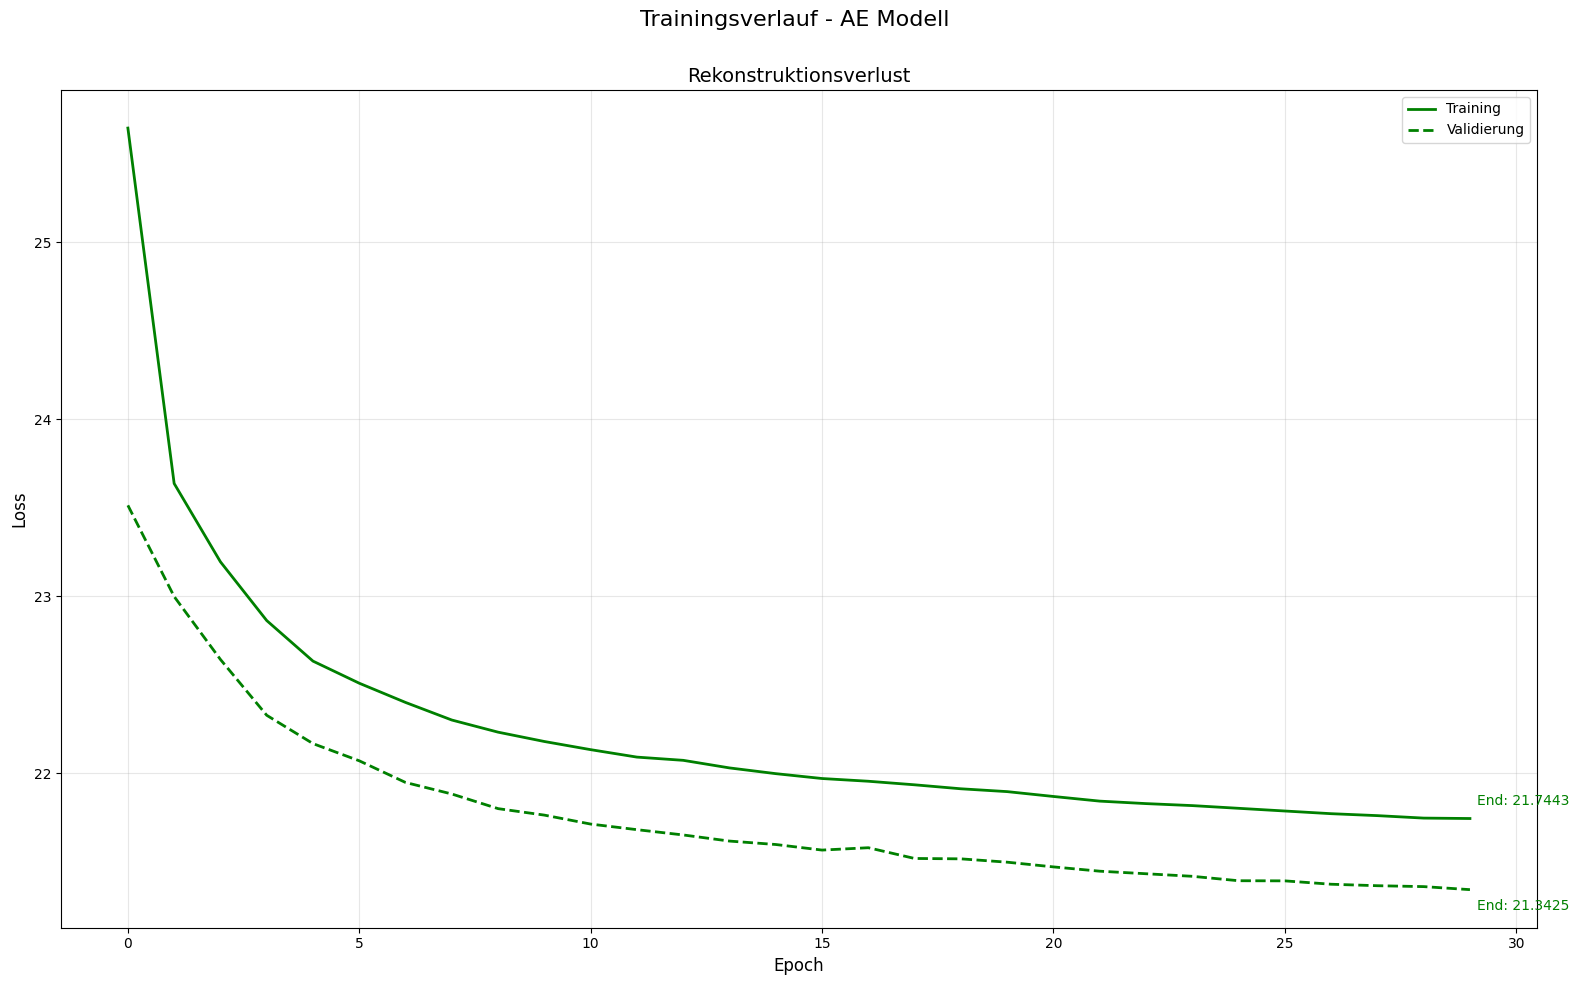

In [45]:
fig, axes = plot_loss_curves(
    history,
    model_type='ae',
    folder_name="ae_results/loss_curves"
)

## 3.Rekonstruktionsfehler berechnen

In [52]:
best_threshold = find_optimal_threshold(uae, X_test, y_test)

<ipython-input-30-c0667f37140f>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/ae_results/reconstruction_plots/reconstruction_analysis_20250301_063946.png


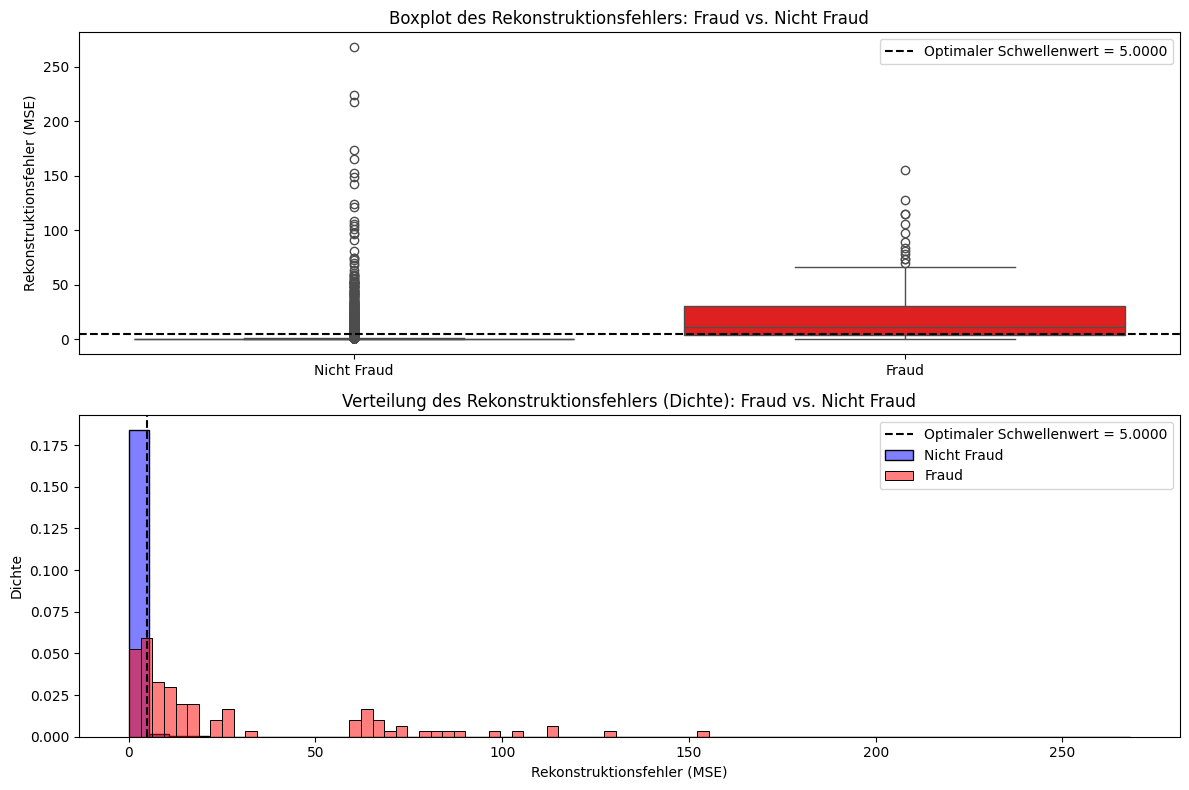

In [53]:
# Visualisierung und Speichern in Google Drive mit Markierung von Fraud vs. Nicht Fraud
plot_reconstruction_analysis(
    uae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    threshold=best_threshold,  # Basierend auf Ihren vorherigen Histogram-Daten für AE
    folder_name="ae_results/reconstruction_plots"
)

In [59]:
# Evaluieren der Fraud-Detektion, Metriken ausgeben und speichern
metrics = evaluate_fraud_detection(
    uae,
    X_test,
    y_test,
    save_metrics=True,  # Speichert Metriken in Google Drive
    folder_name="vae_results/metrics"
)

Optimaler Schwellenwert basierend auf F1-Score: 5.0

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.98      0.99     56864
       Fraud       0.07      0.68      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.83      0.56     56962
weighted avg       1.00      0.98      0.99     56962


Metriken:
Precision: 0.0685
Recall: 0.6837
F1-Score: 0.1245
Accuracy: 0.9835
ROC-AUC: 0.8338
Metriken wurden gespeichert unter: /content/drive/MyDrive/vae_results/metrics/metrics_20250301_064113.txt


## 4.Plot AUC ROC Kurve

Optimaler Schwellenwert basierend auf F1-Score: 5.0
ROC-Kurve wurde gespeichert unter: /content/drive/MyDrive/ae_results/UnsupervisedAEroc_curve_20250301_064121.png
ROC-AUC: 0.9501


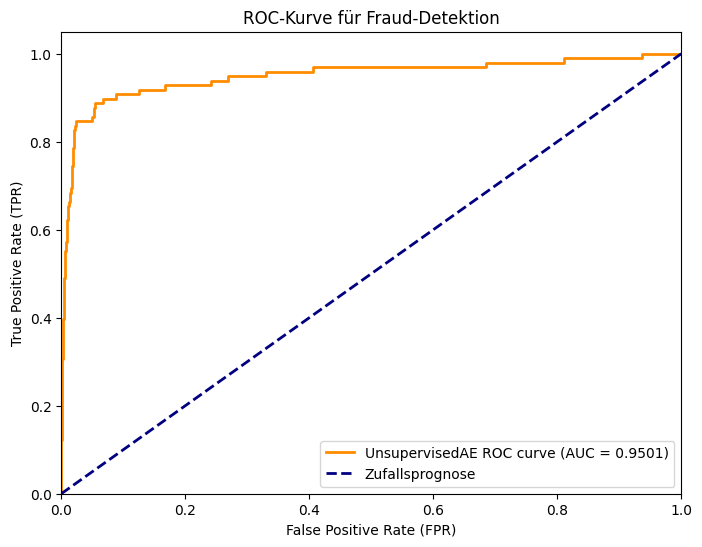

In [60]:
plot_roc_auc_curve(
    uae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="ae_results")

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/ae_results/latent_space/latent_space_UnsupervisedAE_20250301_070038.png


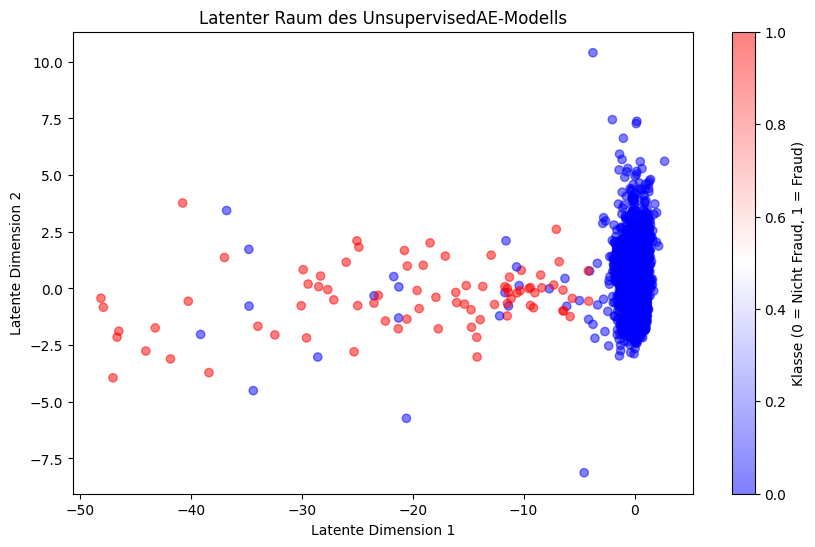

In [79]:
plot_latent_space(
    uae,
    X_test,
    np.squeeze(y_test),
    folder_name="ae_results/latent_space"
)

#II. Unsupervsied VAE  




---



## 1.VAE Klasse definieren

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from typing import List, Optional, Union, Tuple

class UnsupervisedVAE(Model):
    """
    Unüberwachter Variational Autoencoder für Anomalieerkennung.

    Args:
        input_dim (int): Dimension der Eingabedaten.
        latent_dim (int): Dimension des latenten Raums (Standard: 16).
        hidden_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Encoder/Decoder (Standard: [64, 32]).
        activation (str, optional): Aktivierungsfunktion ('relu', 'mish', 'swish'). Standardwert ist 'relu'.
        dropout_rate (float, optional): Dropout-Rate zwischen 0 und 1. Standardwert ist 0.0.
        kl_weight (float, optional): Gewichtungsfaktor für den KL-Verlust. Standardwert ist 1.0.
    """
    def __init__(
        self,
        input_dim: int,
        latent_dim: int = 16,
        hidden_dims: List[int] = [64, 32],
        activation: str = 'relu',
        dropout_rate: float = 0.0,
        kl_weight: float = 1.0
    ):
        super(UnsupervisedVAE, self).__init__()

        # Aktivierungsfunktion direkt definieren
        if activation == 'mish':
            self.activation = lambda x: x * tf.math.tanh(tf.math.softplus(x))
        elif activation == 'swish':
            self.activation = lambda x: x * tf.nn.sigmoid(x)
        elif activation == 'relu':
            self.activation = 'relu'
        else:
            raise ValueError(f"Unbekannte Aktivierungsfunktion: {activation}")

        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.kl_weight = kl_weight

        # Encoder-Schichten mit optionalem Dropout
        self.encoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation)
            for dim in hidden_dims
        ]
        if dropout_rate > 0:
            self.encoder_dropout = layers.Dropout(dropout_rate)

        self.z_mean = layers.Dense(latent_dim)
        self.z_log_var = layers.Dense(latent_dim)

        class Sampling(layers.Layer):
            def call(self, inputs: Tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
                z_mean, z_log_var = inputs
                batch = tf.shape(z_mean)[0]
                dim = tf.shape(z_mean)[1]
                epsilon = tf.random.normal(shape=(batch, dim))
                return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        self.sampling = Sampling()

        # Decoder-Schichten mit optionalem Dropout
        self.decoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation)
            for dim in reversed(hidden_dims)
        ]
        if dropout_rate > 0:
            self.decoder_dropout = layers.Dropout(dropout_rate)

        self.decoder_output = layers.Dense(input_dim, activation='linear')

        # Metriken
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self) -> List[metrics.Metric]:
        """Gibt die Liste der Metriken zurück."""
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def encode(self, x: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Kodierung der Eingabedaten in den latenten Raum.

        Args:
            x: Eingabetensor der Form (Batch-Größe, input_dim).

        Returns:
            Tuple[tf.Tensor, tf.Tensor, tf.Tensor]: (z_mean, z_log_var, z) – Mittelwert, Log-Varianz und gestochastische latente Variable.
        """
        for layer in self.encoder_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.encoder_dropout(x, training=True)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

    def decode(self, z: tf.Tensor) -> tf.Tensor:
        """
        Dekodierung der latenten Variablen in rekonstruierte Daten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim).

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim).
        """
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
            if self.dropout_rate > 0 and layer != self.decoder_layers[-1]:  # Kein Dropout in der letzten Schicht
                x = self.decoder_dropout(x, training=True)
        return self.decoder_output(x)

    def call(self, inputs: tf.Tensor, training: bool = False) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Vorwärtspass durch den VAE.

        Args:
            inputs: Eingabetensor der Form (Batch-Größe, input_dim).
            training: Boolean, der angibt, ob Trainings- oder Inferenzmodus vorliegt.

        Returns:
            Tuple[tf.Tensor, tf.Tensor, tf.Tensor]: (rekonstruiert, z_mean, z_log_var) – Rekonstruierte Daten, Mittelwert und Log-Varianz des latenten Raums.
        """
        z_mean, z_log_var, z = self.encode(inputs)
        reconstructed = self.decode(z)
        return reconstructed, z_mean, z_log_var

    def train_step(self, data: Union[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]) -> Dict[str, float]:
        """
        Trainings-Schritt für den VAE mit MSE- und KL-Verlust.

        Args:
            data: Eingabetensor der Trainingsdaten oder Tuple (x, y) für TensorFlow 2.18.

        Returns:
            Dictionary mit Metrikwerten.
        """
        if isinstance(data, tuple):
            if len(data) == 2:
                x, _ = data  # Ignoriere y, da es unüberwacht ist
            else:
                x = data[0]
        else:
            x = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encode(x)
            reconstruction = self.decode(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=-1))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
            total_loss = reconstruction_loss + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data: Union[tf.Tensor, Tuple[tf.Tensor, tf.Tensor]]) -> Dict[str, float]:
        """
        Test-Schritt für den VAE mit MSE- und KL-Verlust.

        Args:
            data: Eingabetensor der Testdaten oder Tuple (x, y) für TensorFlow 2.18.

        Returns:
            Dictionary mit Metrikwerten.
        """
        if isinstance(data, tuple):
            if len(data) == 2:
                x, _ = data  # Ignoriere y, da es unüberwacht ist
            else:
                x = data[0]
        else:
            x = data

        z_mean, z_log_var, z = self.encode(x)
        reconstruction = self.decode(z)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction), axis=-1))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))
        total_loss = reconstruction_loss + self.kl_weight * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def print_summary(self):
        """
        Gibt eine Zusammenfassung der Modellarchitektur aus.

        Diese Methode verwendet die `summary()`-Methode von TensorFlow/Keras, um die Layer, Parameter und Ausgabetypen anzuzeigen.
        """
        self.summary()

    def build(self, input_shape: Tuple[int, int]) -> None:
        """
        Baut das Modell explizit mit der angegebenen Eingabeform.

        Args:
            input_shape: Tuple der Form (Batch-Größe, input_dim), wobei Batch-Größe optional ist.

        Raises:
            ValueError: Wenn input_shape kein gültiges Tuple ist.
        """
        if isinstance(input_shape, tuple) and len(input_shape) >= 1:
            input_dim = input_shape[-1]  # Nehme die letzte Dimension als input_dim
        else:
            raise ValueError("input_shape muss ein Tuple sein, z. B. (None, input_dim)")

        # Erstelle ein Dummy-Input-Tensor, um das Modell zu bauen
        dummy_input = tf.zeros((1, input_dim), dtype=tf.float32)
        self.call(dummy_input, training=False)  # Baut das Modell, indem es auf Dummy-Daten angewendet wird


In [62]:
uvae = UnsupervisedVAE(
    input_dim=X_train_normal.shape[1],
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    activation=activation,
    dropout_rate=0.1,
    kl_weight=kl_weight
)

## 2.Trainiern VAE unsupervised

In [63]:
uvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
history_uvae = uvae.fit(
    X_train_normal,
    epochs=epoch,
    batch_size=256,
    validation_split=0.2,
    verbose=0
)
# Ausgabe der Modellzusammenfassung
uvae.print_summary()

Model: "unsupervised_vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 64)                  │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling (Sampling)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 29)                  │           1,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,793 (112.48 KB)

 Trainable params: 9,597 (37.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,196 (74.99 KB)

Plot wurde gespeichert unter: /content/drive/MyDrive/vae_results/loss_curves/loss_curves_vae_20250301_064504.png


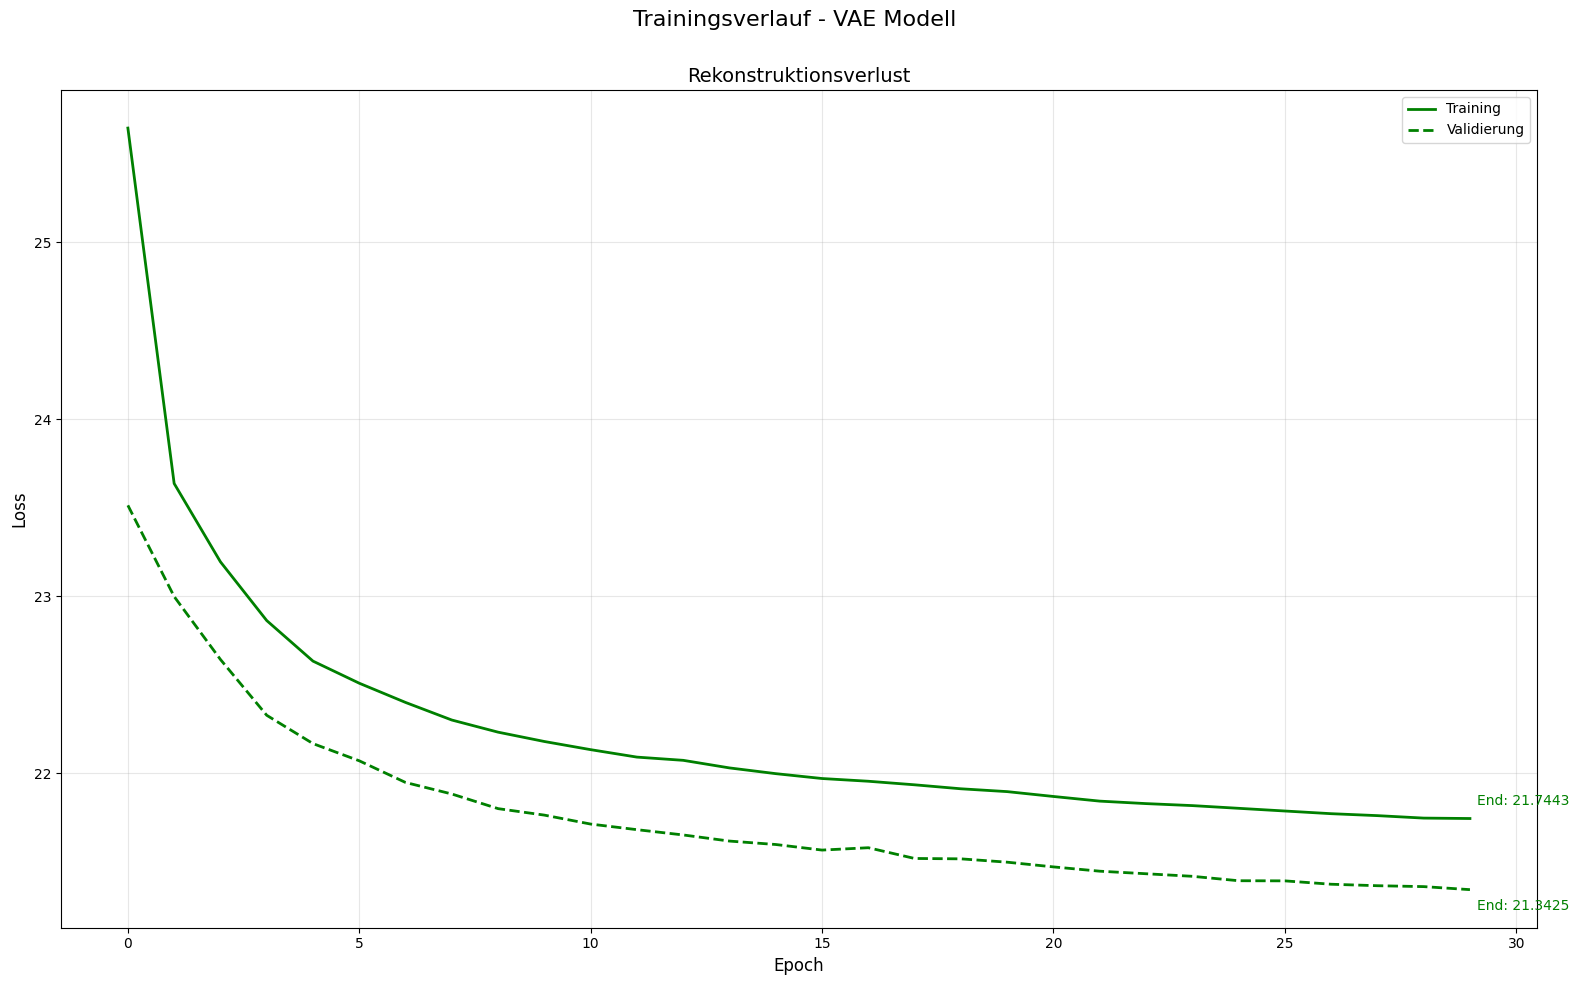

In [64]:
fig, axes = plot_loss_curves(history,model_type='vae',folder_name="vae_results/loss_curves")

## 3.Rekonstruktiosnfehler berechnen

In [65]:
metrics_vae = evaluate_fraud_detection(
    uvae,
    X_test,
    y_test,
    save_metrics=True,  # Speichert Metriken in Google Drive
    folder_name="vae_results/metrics"
)

Optimaler Schwellenwert basierend auf F1-Score: 3.564646464646465

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      1.00      1.00     56864
       Fraud       0.24      0.47      0.32        98

    accuracy                           1.00     56962
   macro avg       0.62      0.73      0.66     56962
weighted avg       1.00      1.00      1.00     56962


Metriken:
Precision: 0.2434
Recall: 0.4694
F1-Score: 0.3206
Accuracy: 0.9966
ROC-AUC: 0.7334
Metriken wurden gespeichert unter: /content/drive/MyDrive/vae_results/metrics/metrics_20250301_064507.txt


In [66]:
optimal_threshold, _ = find_optimal_threshold(uvae, X_test, y_test)

## 4.Visualisierung der Rekonstruktionsanalyse

<ipython-input-30-c0667f37140f>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/vae_results/reconstruction_analysis/reconstruction_analysis_20250301_064510.png


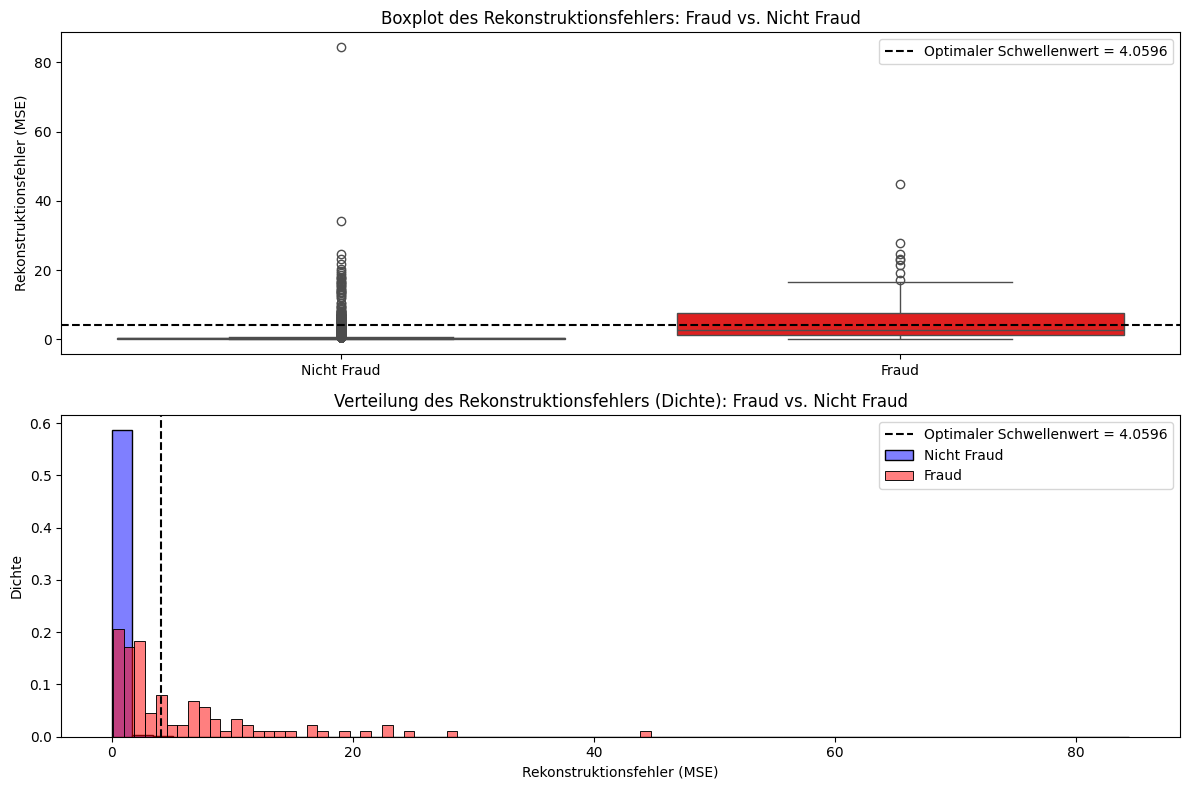

In [67]:
plot_reconstruction_analysis(
    uvae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    threshold=optimal_threshold,  # Verwende den optimalen Schwellenwert
    folder_name="vae_results/reconstruction_analysis"
    )

## 5.Visualisierung des Klassifikationsberichts

In [68]:
# Evaluieren der Fraud-Detektion, Metriken ausgeben und speichern
metrics = evaluate_fraud_detection(
    uvae,
    X_test,
    y_test,
    save_metrics=True,  # Speichert Metriken in Google Drive
    folder_name="vae_results/metrics"
)

Optimaler Schwellenwert basierend auf F1-Score: 3.465656565656566

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      1.00      1.00     56864
       Fraud       0.22      0.45      0.30        98

    accuracy                           1.00     56962
   macro avg       0.61      0.72      0.65     56962
weighted avg       1.00      1.00      1.00     56962


Metriken:
Precision: 0.2200
Recall: 0.4490
F1-Score: 0.2953
Accuracy: 0.9963
ROC-AUC: 0.7231
Metriken wurden gespeichert unter: /content/drive/MyDrive/vae_results/metrics/metrics_20250301_064515.txt


## 6.Plot AUC ROC

Optimaler Schwellenwert basierend auf F1-Score: 5.0
ROC-Kurve wurde gespeichert unter: /content/drive/MyDrive/vae_results/UnsupervisedAEroc_curve_20250301_064516.png
ROC-AUC: 0.9507


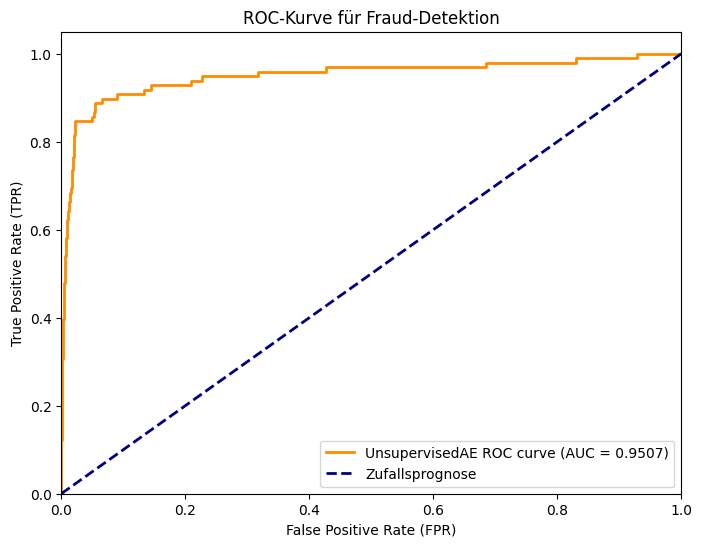

In [69]:
plot_roc_auc_curve(
    uvae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="vae_results")

## 7.Plot latent space

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/vae_results/latent_space/latent_space_20250301_064816.png


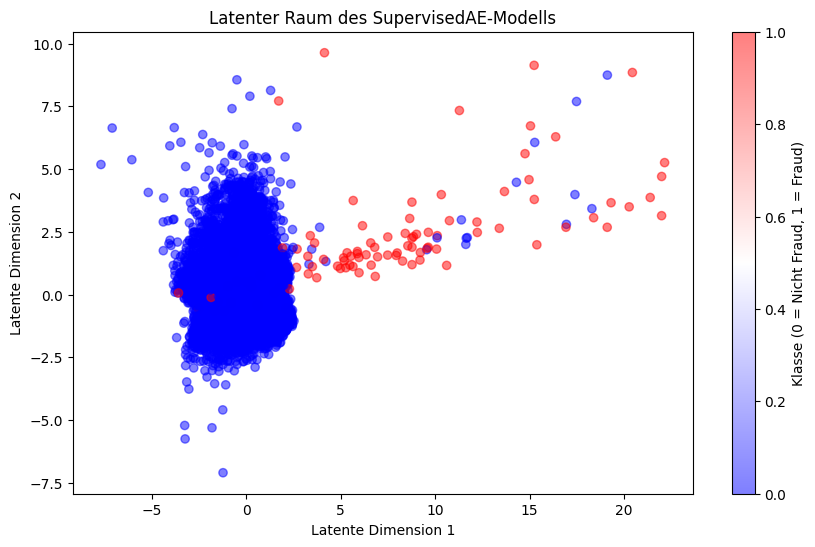

In [74]:
plot_latent_space(
    uvae,
    X_test,
    np.squeeze(y_test),
    folder_name="vae_results/latent_space"
)

#III. Supervised AE

## 1.Klasse SAE definieren

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from typing import List, Optional, Union, Tuple, Dict

class SupervisedAE(Model):
    """
    Überwachter Autoencoder für Anomalieerkennung mit Klassifikation.

    Args:
        input_dim (int): Dimension der Eingabedaten.
        hidden_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Encoder/Decoder (Standard: [64, 32]).
        latent_dim (int): Dimension des latenten Raums (Standard: 32).
        classifier_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Klassifikator (Standard: [16]).
        activation (str, optional): Aktivierungsfunktion ('relu', 'mish', 'swish'). Standardwert ist 'relu'.
        dropout_rate (float, optional): Dropout-Rate zwischen 0 und 1. Standardwert ist 0.0.
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [64, 32],
        latent_dim: int = 32,
        classifier_dims: int=16,
        activation: str = 'relu',
        dropout_rate: float = 0.0
    ):
        super(SupervisedAE, self).__init__()

        # Aktivierungsfunktion direkt definieren
        if activation == 'mish':
            self.activation = lambda x: x * tf.math.tanh(tf.math.softplus(x))
        elif activation == 'swish':
            self.activation = lambda x: x * tf.nn.sigmoid(x)
        elif activation == 'relu':
            self.activation = 'relu'
        else:
            raise ValueError(f"Unbekannte Aktivierungsfunktion: {activation}")

        self.dropout_rate = dropout_rate

        # Encoder-Schichten mit optionalem Dropout
        self.encoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
            for dim in hidden_dims
        ]
        if dropout_rate > 0:
            self.encoder_dropout = layers.Dropout(dropout_rate)

        # Latente Schicht im Encoder
        self.latent_layer = layers.Dense(latent_dim, activation=None, dtype=tf.float32)  # Keine Aktivierung für latenten Raum

        # Decoder-Schichten mit optionalem Dropout
        self.decoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
            for dim in reversed(hidden_dims)
        ]
        if dropout_rate > 0:
            self.decoder_dropout = layers.Dropout(dropout_rate)

        self.decoder_output = layers.Dense(input_dim, activation='linear', dtype=tf.float32)

        # Klassifikator-Schichten mit optionalem Dropout
        #self.classifier_layer = layers.Dense(classifier_dims, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
        #if dropout_rate > 0:
        #    self.classifier_dropout = layers.Dropout(dropout_rate)

        # Klassifikator-Ausgabe: Hier wird eine Wahrscheinlichkeit ausgegeben

        self.classifier_output = layers.Dense(1, activation='sigmoid', dtype=tf.float32)

        # Metriken
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss", dtype=tf.float32)
        self.classification_loss_tracker = metrics.Mean(name="classification_loss", dtype=tf.float32)
        self.total_loss_tracker = metrics.Mean(name="total_loss", dtype=tf.float32)

    @property
    def metrics(self) -> List[metrics.Metric]:
        """Gibt die Liste der Metriken zurück."""
        return [
            self.reconstruction_loss_tracker,
            self.classification_loss_tracker,
            self.total_loss_tracker,
        ]

    def encode(self, x: tf.Tensor) -> tf.Tensor:
        """
        Kodierung der Eingabedaten in den latenten Raum.

        Args:
            x: Eingabetensor der Form (Batch-Größe, input_dim), erwartet tf.float32.

        Returns:
            Latenter Tensor der Form (Batch-Größe, latent_dim), als tf.float32.
        """
        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        for layer in self.encoder_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.encoder_dropout(x, training=True)
        return self.latent_layer(x)

    def decode(self, z: tf.Tensor) -> tf.Tensor:
        """
        Dekodierung der latenten Variablen in rekonstruierte Daten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim), erwartet tf.float32.

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim), als tf.float32.
        """
        if z.dtype != tf.float32:
            z = tf.cast(z, tf.float32)  # Konvertiere explizit zu float32
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
            if self.dropout_rate > 0 and layer != self.decoder_layers[-1]:  # Kein Dropout in der letzten Schicht
                x = self.decoder_dropout(x, training=True)
        return self.decoder_output(x)

    def classify(self, z: tf.Tensor) -> tf.Tensor:
        """
        Klassifikation der latenten Variablen in Betrugswahrscheinlichkeiten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim), erwartet tf.float32.

        Returns:
            Tensor der Form (Batch-Größe, 1) mit Wahrscheinlichkeiten (0-1), als tf.float32.
        """
        if z.dtype != tf.float32:
            z = tf.cast(z, tf.float32)  # Konvertiere explizit zu float32
        x = z
        return self.classifier_output(x)

    def call(self, inputs: tf.Tensor, training: bool = False) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Vorwärtspass durch den SupervisedAE.

        Args:
            inputs: Eingabetensor der Form (Batch-Größe, input_dim), erwartet tf.float32.
            training: Boolean, der angibt, ob Trainings- oder Inferenzmodus vorliegt.

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: (rekonstruiert, klassifiziert) – Rekonstruierte Daten und Klassifikationswahrscheinlichkeiten, beide als tf.float32.
        """
        if inputs.dtype != tf.float32:
            inputs = tf.cast(inputs, tf.float32)  # Konvertiere explizit zu float32
        encoded = self.encode(inputs)
        reconstructed = self.decode(encoded)
        classification = self.classify(encoded)
        return reconstructed, classification

    def train_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, tf.Tensor]:
        """
        Trainings-Schritt für den SupervisedAE mit MSE- und Binary Crossentropy-Verlust.

        Args:
            data: Tuple (x, y) mit Eingabedaten und Labels für TensorFlow 2.x, beide als tf.float32.

        Returns:
            Dictionary mit Metrikwerten.
        """
        x, y = data

        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        if y.dtype != tf.float32:
            y = tf.cast(y, tf.float32)  # Konvertiere explizit zu float32

        # Formatiere y zu Shape (batch_size, 1), um mit der Klassifikationsausgabe übereinzustimmen
        if len(y.shape) == 1:
            y = tf.expand_dims(y, axis=-1)  # Füge eine Dimension hinzu: (batch_size,) -> (batch_size, 1)

        with tf.GradientTape() as tape:
            reconstructed, classification = self(x, training=True)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))
            classification_loss = tf.keras.losses.binary_crossentropy(y, classification)
            total_loss = reconstruction_loss + tf.reduce_mean(classification_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.total_loss_tracker.update_state(total_loss)

        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, tf.Tensor]:
        """
        Test-Schritt für den SupervisedAE mit MSE- und Binary Crossentropy-Verlust.

        Args:
            data: Tuple (x, y) mit Eingabedaten und Labels für TensorFlow 2.x, beide als tf.float32.

        Returns:
            Dictionary mit Metrikwerten.
        """
        x, y = data

        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        if y.dtype != tf.float32:
            y = tf.cast(y, tf.float32)  # Konvertiere explizit zu float32

        # Formatiere y zu Shape (batch_size, 1), um mit der Klassifikationsausgabe übereinzustimmen
        if len(y.shape) == 1:
            y = tf.expand_dims(y, axis=-1)  # Füge eine Dimension hinzu: (batch_size,) -> (batch_size, 1)

        reconstructed, classification = self(x, training=False)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))
        classification_loss = tf.keras.losses.binary_crossentropy(y, classification)
        total_loss = reconstruction_loss + tf.reduce_mean(classification_loss)

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.total_loss_tracker.update_state(total_loss)

        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def print_summary(self):
        """
        Gibt eine Zusammenfassung der Modellarchitektur aus.

        Diese Methode verwendet die `summary()`-Methode von TensorFlow/Keras, um die Layer, Parameter und Ausgabetypen anzuzeigen.
        """
        self.summary()

    def build(self, input_shape: Tuple[int, int]) -> None:
        """
        Baut das Modell explizit mit der angegebenen Eingabeform.

        Args:
            input_shape: Tuple der Form (Batch-Größe, input_dim), wobei Batch-Größe optional ist.

        Raises:
            ValueError: Wenn input_shape kein gültiges Tuple ist.
        """
        if isinstance(input_shape, tuple) and len(input_shape) >= 1:
            input_dim = input_shape[-1]  # Nehme die letzte Dimension als input_dim
        else:
            raise ValueError("input_shape muss ein Tuple sein, z. B. (None, input_dim)")

        # Erstelle ein Dummy-Input-Tensor, um das Modell zu bauen
        dummy_input = tf.zeros((1, input_dim), dtype=tf.float32)
        self.call(dummy_input, training=False)  # Baut das Modell, indem es auf Dummy-Daten angewendet wird

In [82]:
# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
# Konvertiere X und y zu float32 für TensorFlow
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

## 2.Trainieren des SupervisedAE

In [84]:
sae = SupervisedAE(
    input_dim=X_train.shape[1],
    hidden_dims=hidden_dims,
    latent_dim=latent_dim,
    classifier_dims=classifier_dim,
    activation='mish',
    dropout_rate=0.1
)
sae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [85]:
history_sae = sae.fit(
    X_train, y_train,  # Tuple mit X_train und y_train
    epochs=epoch,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0
)

In [86]:
sae.print_summary()

Model: "supervised_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 64)                  │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 29)                  │           1,885 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,076 (109.68 KB)

 Trainable params: 9,358 (36.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,718 (73.12 KB)

Plott alle Loss

Plot wurde gespeichert unter: /content/drive/MyDrive/sae_results/loss_curves/loss_curves_sae_20250301_070539.png


(<Figure size 1600x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Rekonstruktionsverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Klassifikationsverlust'}, xlabel='Epoch', ylabel='Loss'>],
       dtype=object))

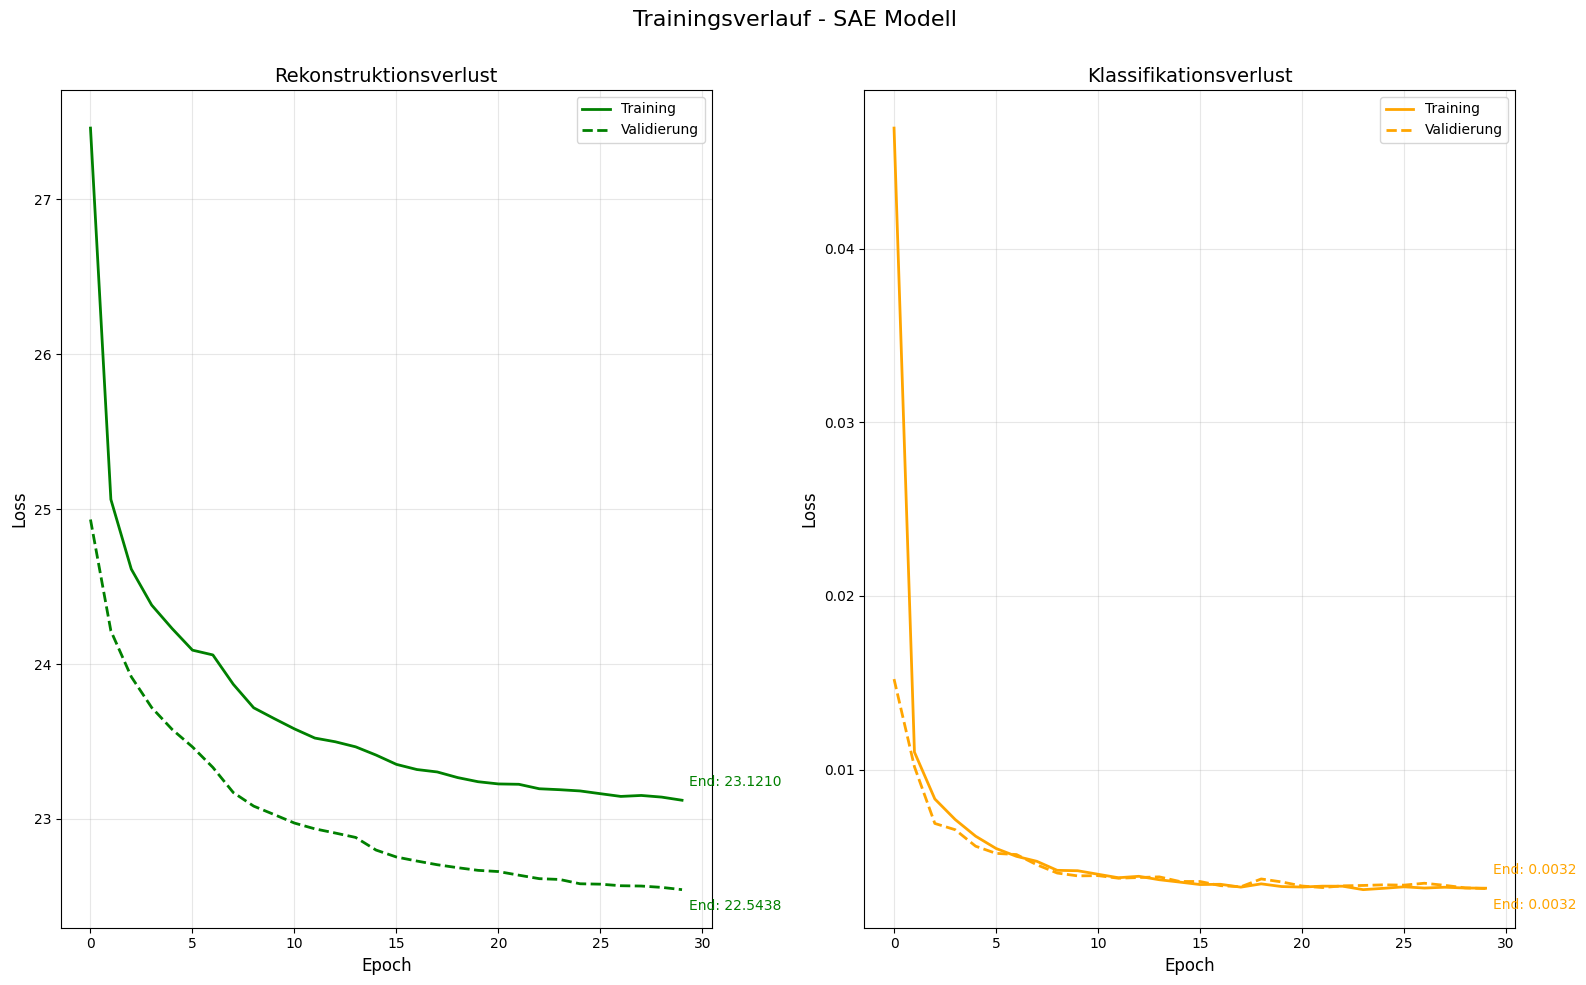

In [87]:
plot_loss_curves(history_sae,model_type='sae',folder_name="sae_results/loss_curves")

In [88]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score

## 3.Visualisierung der Rekonstruktionsanalyse

<ipython-input-30-c0667f37140f>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/sae_results/reconstruction_analysis/reconstruction_analysis_20250301_071048.png


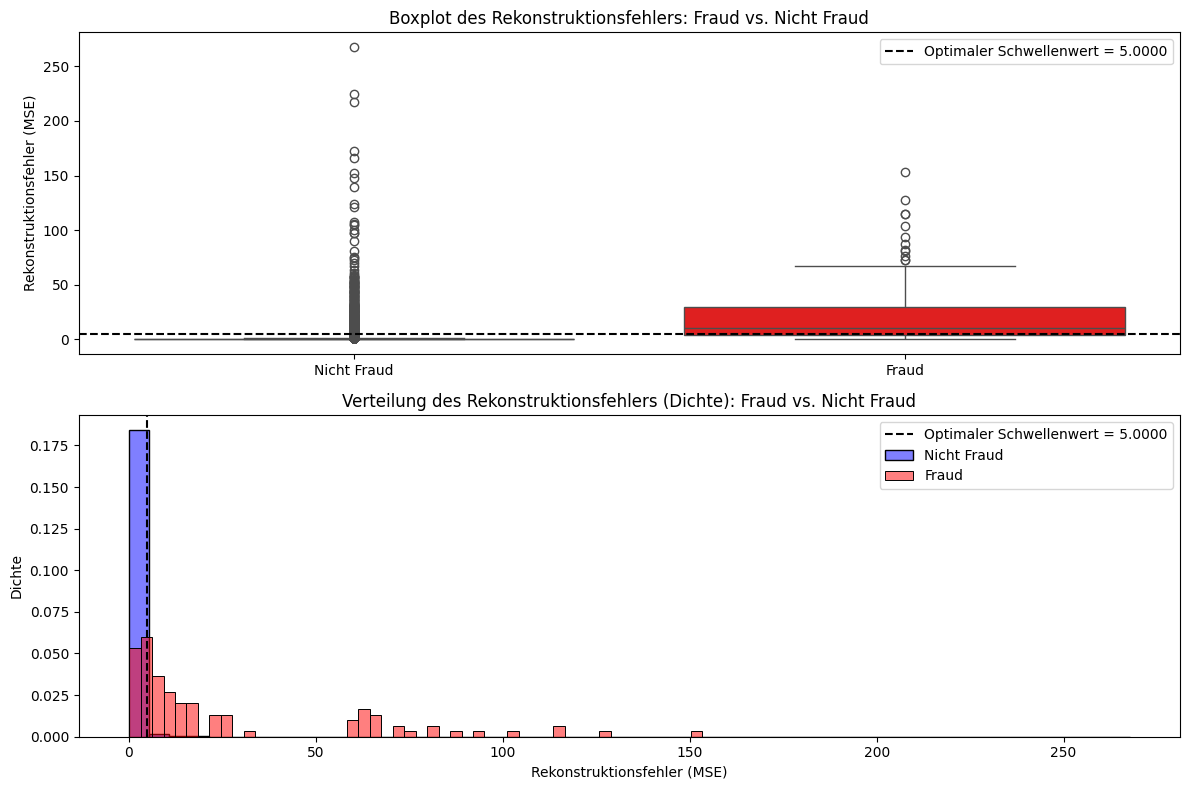

In [93]:
plot_reconstruction_analysis(
    sae,
    X_test,
    y_test,  # Labels für Testdaten (0 für Nicht Fraud, 1 für Fraud)
    folder_name="sae_results/reconstruction_analysis"
    )

In [89]:
# Berechnung des Rekonstruktionsfehlers
sae_reconstruction_error = calculate_reconstruction_error(sae, X_test)

## 4.Plot AUC ROC

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Classification Performance:
Accuracy: 0.9993
Precision: 0.7917
Recall: 0.7755
F1 Score: 0.7835


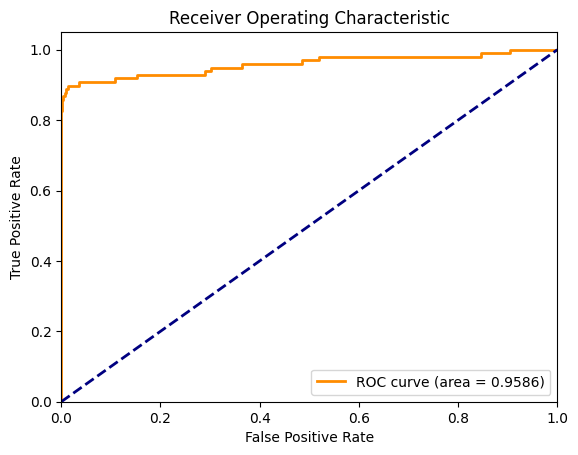

In [135]:
# Evaluate the classifier on test data
_, y_pred_prob_sae = sae.predict(X_test)
y_pred_sae = (y_pred_prob_sae > 0.5).astype(int)  # Apply threshold at 0.5

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_sae)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_sae, average='binary')

print(f"Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_sae)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Clasifikation report

In [136]:
classification_report_sae = classification_report(y_test, y_pred_sae)
print(classification_report_sae)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.79      0.78      0.78        98

    accuracy                           1.00     56962
   macro avg       0.90      0.89      0.89     56962
weighted avg       1.00      1.00      1.00     56962



## 5.Plot latent space

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/sae_results/latent_space/latent_space_SupervisedAE_20250301_070729.png


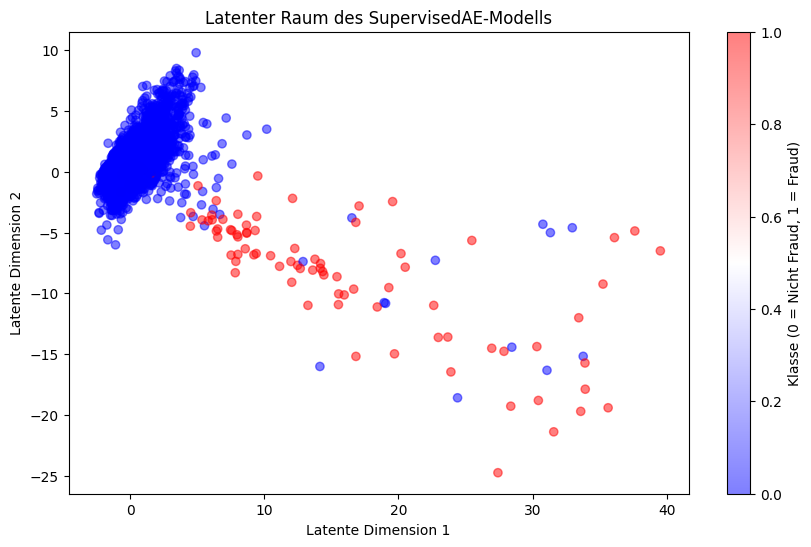

In [91]:
# Extract the latent representations
plot_latent_space(sae, X_test, y_test, folder_name="sae_results/latent_space")

#IV. Supervised VAE

##1.Klasse SVAE def

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Model, metrics
from typing import List, Optional, Union, Tuple, Dict
class SupervisedVAE(Model):
    """
    Überwachter Variational Autoencoder für Anomalieerkennung mit Klassifikation.

    Args:
        input_dim (int): Dimension der Eingabedaten.
        hidden_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Encoder/Decoder (Standard: [64, 32]).
        latent_dim (int): Dimension des latenten Raums (Standard: 16).
        classifier_dims (List[int]): Liste der Dimensionen der versteckten Schichten im Klassifikator (Standard: [16]).
        activation (str, optional): Aktivierungsfunktion ('relu', 'mish', 'swish'). Standardwert ist 'relu'.
        dropout_rate (float, optional): Dropout-Rate zwischen 0 und 1. Standardwert ist 0.0.
        kl_weight (float, optional): Gewichtungsfaktor für den KL-Verlust. Standardwert ist 1.0.
    """
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [64, 32],
        latent_dim: int = 16,
        classifier_dims: List[int] = [16],
        activation: str = 'relu',
        dropout_rate: float = 0.0,
        kl_weight: float = 1.0
    ):
        super(SupervisedVAE, self).__init__()

        # Aktivierungsfunktion direkt definieren
        if activation == 'mish':
            self.activation = lambda x: x * tf.math.tanh(tf.math.softplus(x))
        elif activation == 'swish':
            self.activation = lambda x: x * tf.nn.sigmoid(x)
        elif activation == 'relu':
            self.activation = 'relu'
        else:
            raise ValueError(f"Unbekannte Aktivierungsfunktion: {activation}")

        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.kl_weight = kl_weight

        # Encoder-Schichten mit optionalem Dropout
        self.encoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
            for dim in hidden_dims
        ]
        if dropout_rate > 0:
            self.encoder_dropout = layers.Dropout(dropout_rate)

        self.z_mean = layers.Dense(latent_dim, dtype=tf.float32)
        self.z_log_var = layers.Dense(latent_dim, dtype=tf.float32)

        class Sampling(layers.Layer):
            def call(self, inputs: Tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
                z_mean, z_log_var = inputs
                batch = tf.shape(z_mean)[0]
                dim = tf.shape(z_mean)[1]
                epsilon = tf.random.normal(shape=(batch, dim), dtype=tf.float32)
                return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        self.sampling = Sampling()

        # Decoder-Schichten mit optionalem Dropout
        self.decoder_layers = [
            layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
            for dim in reversed(hidden_dims)
        ]
        if dropout_rate > 0:
            self.decoder_dropout = layers.Dropout(dropout_rate)

        self.decoder_output = layers.Dense(input_dim, activation='linear', dtype=tf.float32)

        # Klassifikator-Schichten mit optionalem Dropout
        #self.classifier_layers = [
        #    layers.Dense(dim, activation=self.activation if callable(self.activation) else self.activation, dtype=tf.float32)
        #    for dim in classifier_dims
        #]
        #if dropout_rate > 0:
        #    self.classifier_dropout = layers.Dropout(dropout_rate)

        self.classifier_output = layers.Dense(1, activation='sigmoid', dtype=tf.float32)

        # Metriken
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss", dtype=tf.float32)
        self.classification_loss_tracker = metrics.Mean(name="classification_loss", dtype=tf.float32)
        self.kl_loss_tracker = metrics.Mean(name="kl_loss", dtype=tf.float32)
        self.total_loss_tracker = metrics.Mean(name="total_loss", dtype=tf.float32)

    @property
    def metrics(self) -> List[metrics.Metric]:
        """Gibt die Liste der Metriken zurück."""
        return [
            self.reconstruction_loss_tracker,
            self.classification_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker,
        ]

    def encode(self, x: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Kodierung der Eingabedaten in den latenten Raum.

        Args:
            x: Eingabetensor der Form (Batch-Größe, input_dim), erwartet tf.float32.

        Returns:
            Tuple[tf.Tensor, tf.Tensor, tf.Tensor]: (z_mean, z_log_var, z) – Mittelwert, Log-Varianz und gestochastische latente Variable, alle als tf.float32.
        """
        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        for layer in self.encoder_layers:
            x = layer(x)
            if self.dropout_rate > 0:
                x = self.encoder_dropout(x, training=True)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling([z_mean, z_log_var])
        return z_mean, z_log_var, z

    def decode(self, z: tf.Tensor) -> tf.Tensor:
        """
        Dekodierung der latenten Variablen in rekonstruierte Daten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim), erwartet tf.float32.

        Returns:
            Rekonstruierter Tensor der Form (Batch-Größe, input_dim), als tf.float32.
        """
        if z.dtype != tf.float32:
            z = tf.cast(z, tf.float32)  # Konvertiere explizit zu float32
        x = z
        for layer in self.decoder_layers:
            x = layer(x)
            if self.dropout_rate > 0 and layer != self.decoder_layers[-1]:  # Kein Dropout in der letzten Schicht
                x = self.decoder_dropout(x, training=True)
        return self.decoder_output(x)

    def classify(self, z: tf.Tensor) -> tf.Tensor:
        """
        Klassifikation der latenten Variablen in Betrugswahrscheinlichkeiten.

        Args:
            z: Latenter Tensor der Form (Batch-Größe, latent_dim), erwartet tf.float32.

        Returns:
            Tensor der Form (Batch-Größe, 1) mit Wahrscheinlichkeiten (0-1), als tf.float32.
        """
        if z.dtype != tf.float32:
            z = tf.cast(z, tf.float32)  # Konvertiere explizit zu float32
        x = z
        #if self.dropout_rate > 0:
         #       x = self.classifier_dropout(x, training=True)
        return self.classifier_output(x)

    def call(self, inputs: tf.Tensor, training: bool = False) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Vorwärtspass durch den SupervisedVAE.

        Args:
            inputs: Eingabetensor der Form (Batch-Größe, input_dim), erwartet tf.float32.
            training: Boolean, der angibt, ob Trainings- oder Inferenzmodus vorliegt.

        Returns:
            Tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]: (rekonstruiert, z_mean, z_log_var, klassifiziert) – Rekonstruierte Daten, Mittelwert, Log-Varianz des latenten Raums und Klassifikationswahrscheinlichkeiten, alle als tf.float32.
        """
        if inputs.dtype != tf.float32:
            inputs = tf.cast(inputs, tf.float32)  # Konvertiere explizit zu float32
        z_mean, z_log_var, z = self.encode(inputs)
        reconstructed = self.decode(z)
        classification = self.classify(z_mean)  # Verwende z_mean für Klassifikation
        return reconstructed, z_mean, z_log_var, classification

    def train_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
        """
        Trainings-Schritt für den SupervisedVAE mit MSE-, Binary Crossentropy- und KL-Verlust.
        """
        # Debugging und Datenextraktion (wie zuvor)
        x, y = data
        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)
        if y.dtype != tf.float32:
            y = tf.cast(y, tf.float32)
        if len(y.shape) == 1:
            y = tf.expand_dims(y, axis=-1)

        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var, classification = self.call(x, training=True)

            # Rekonstruktionsverlust (MSE)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))

            # Klassifikationsverlust (Binary Crossentropy)
            classification_loss = tf.keras.losses.binary_crossentropy(y, classification)

            # KL-Verlust
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))

            # Gesamtverlust
            total_loss = reconstruction_loss + tf.reduce_mean(classification_loss) + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Aktualisiere Metriken, einschließlich 'loss'
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)  # Speichere 'loss' als total_loss

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data: Tuple[tf.Tensor, tf.Tensor]) -> Dict[str, float]:
        """
        Test-Schritt für den SupervisedVAE mit MSE-, Binary Crossentropy- und KL-Verlust.

        Args:
            data: Tuple (x, y) mit Eingabedaten und Labels für TensorFlow 2.18, beide als tf.float32.

        Returns:
            Dictionary mit Metrikwerten.
        """
        x, y = data

        if x.dtype != tf.float32:
            x = tf.cast(x, tf.float32)  # Konvertiere explizit zu float32
        if y.dtype != tf.float32:
            y = tf.cast(y, tf.float32)  # Konvertiere explizit zu float32

        # Formatiere y zu Shape (batch_size, 1), um mit der Klassifikationsausgabe übereinzustimmen
        if len(y.shape) == 1:
            y = tf.expand_dims(y, axis=-1)  # Füge eine Dimension hinzu: (batch_size,) -> (batch_size, 1)

        reconstructed, z_mean, z_log_var, classification = self.call(x, training=False)

        # Rekonstruktionsverlust (MSE)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstructed), axis=-1))

        # Klassifikationsverlust (Binary Crossentropy)
        classification_loss = tf.keras.losses.binary_crossentropy(y, classification)

        # KL-Verlust
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1))

        # Gesamtverlust
        total_loss = reconstruction_loss + tf.reduce_mean(classification_loss) + self.kl_weight * kl_loss

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.classification_loss_tracker.update_state(classification_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)  # Speichere 'loss' als total_loss

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def print_summary(self):
        """
        Gibt eine Zusammenfassung der Modellarchitektur aus.

        Diese Methode verwendet die `summary()`-Methode von TensorFlow/Keras, um die Layer, Parameter und Ausgabetypen anzuzeigen.
        """
        self.summary()

    def build(self, input_shape: Tuple[int, int]) -> None:
        """
        Baut das Modell explizit mit der angegebenen Eingabeform.

        Args:
            input_shape: Tuple der Form (Batch-Größe, input_dim), wobei Batch-Größe optional ist.

        Raises:
            ValueError: Wenn input_shape kein gültiges Tuple ist.
        """
        if isinstance(input_shape, tuple) and len(input_shape) >= 1:
            input_dim = input_shape[-1]  # Nehme die letzte Dimension als input_dim
        else:
            raise ValueError("input_shape muss ein Tuple sein, z. B. (None, input_dim)")

        # Erstelle ein Dummy-Input-Tensor, um das Modell zu bauen
        dummy_input = tf.zeros((1, input_dim), dtype=tf.float32)
        self.call(dummy_input, training=False)  # Baut das Modell, indem es auf Dummy-Daten angewendet wird


In [95]:
# Konvertiere X und y zu float32 für TensorFlow und forme y zu (batch_size, 1)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = np.expand_dims(y_train.astype(np.float32), axis=-1)  # Shape (n_samples, 1)
y_test = np.expand_dims(y_test.astype(np.float32), axis=-1)    # Shape (n_samples, 1)

# Debugging-Ausgabe, um die Formate zu überprüfen
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train unique values:", np.unique(y_train))
print("y_train dtype:", y_train.dtype)
print("X_train dtype:", X_train.dtype)

X_train shape: (227845, 29)
y_train shape: (227845, 1)
y_train unique values: [0. 1.]
y_train dtype: float32
X_train dtype: float32


## 2.Trainieren

In [119]:
svae = SupervisedVAE(
    input_dim=X_train.shape[1],
    hidden_dims=hidden_dims,
    latent_dim=latent_dim,
    classifier_dims=classifier_dim,
    activation=activation,
    dropout_rate=dropout_rate,
    kl_weight=kl_weight
)
svae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [120]:
history_svae = svae.fit(
    X_train, y_train,  # Tuple mit X_train und y_train
    epochs=5,
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - classification_loss: 0.0885 - kl_loss: 6.3975 - loss: 38.7227 - reconstruction_loss: 32.2367 - val_classification_loss: 0.0061 - val_kl_loss: 0.9666 - val_loss: 30.5193 - val_reconstruction_loss: 29.5466
Epoch 2/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - classification_loss: 0.0056 - kl_loss: 1.0095 - loss: 30.9398 - reconstruction_loss: 29.9247 - val_classification_loss: 0.0052 - val_kl_loss: 1.2147 - val_loss: 30.1172 - val_reconstruction_loss: 28.8973
Epoch 3/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - classification_loss: 0.0051 - kl_loss: 1.3176 - loss: 30.6705 - reconstruction_loss: 29.3478 - val_classification_loss: 0.0050 - val_kl_loss: 1.4806 - val_loss: 29.8421 - val_reconstruction_loss: 28.3566
Epoch 4/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - classification_loss: 0.0044 - kl_loss: 1.4799 - loss: 31.0259 - reconstruction_loss: 29.5416 - val_classification_loss: 0.0040 - val_kl_loss: 1.5054 - val_loss: 29.

In [121]:
# Ausgabe der Modellzusammenfassung
svae.print_summary()

Model: "supervised_vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                     │ (None, 64)                  │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling_3 (Sampling)                │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 29)                  │           1,885 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,660 (115.86 KB)

 Trainable params: 9,886 (38.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,774 (77.25 KB)

In [183]:
svae.save_model_to_drive()

ValueError: The filename must end in `.weights.h5`. Received: filepath=/content/drive/MyDrive/vae_results/models/svae_model_20250301_102442.h5

In [122]:
# Bestimmen des optimalen Schwellenwerts
optimal_threshold, _ = find_optimal_threshold(svae, X_test, np.squeeze(y_test))  # Squeeze y_test, um (n_samples,) zu erhalten
print(f"Optimaler Schwellenwert basierend auf F1-Score: {optimal_threshold}")


Optimaler Schwellenwert basierend auf F1-Score: 5.0


## 3.Visualisireung der Rekonstruktionsanalyse

In [160]:
plot_loss_curves(history_svae,model_type="svae", folder_name="svae_results/loss_curves")

Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/svae_results/loss_curves/loss_curves_svae_20250301_092247.png


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'Gesamtverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Rekonstruktionsverlust'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'KL-Divergenz'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Klassifikationsverlust'}, xlabel='Epoch', ylabel='Loss'>],
       dtype=object))

<ipython-input-30-c0667f37140f>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=labels, y=data, palette={'Nicht Fraud': 'blue', 'Fraud': 'red'})


Analyse wurde gespeichert unter: /content/drive/MyDrive/vae_results/reconstruction_analysis/reconstruction_analysis_20250301_081800.png


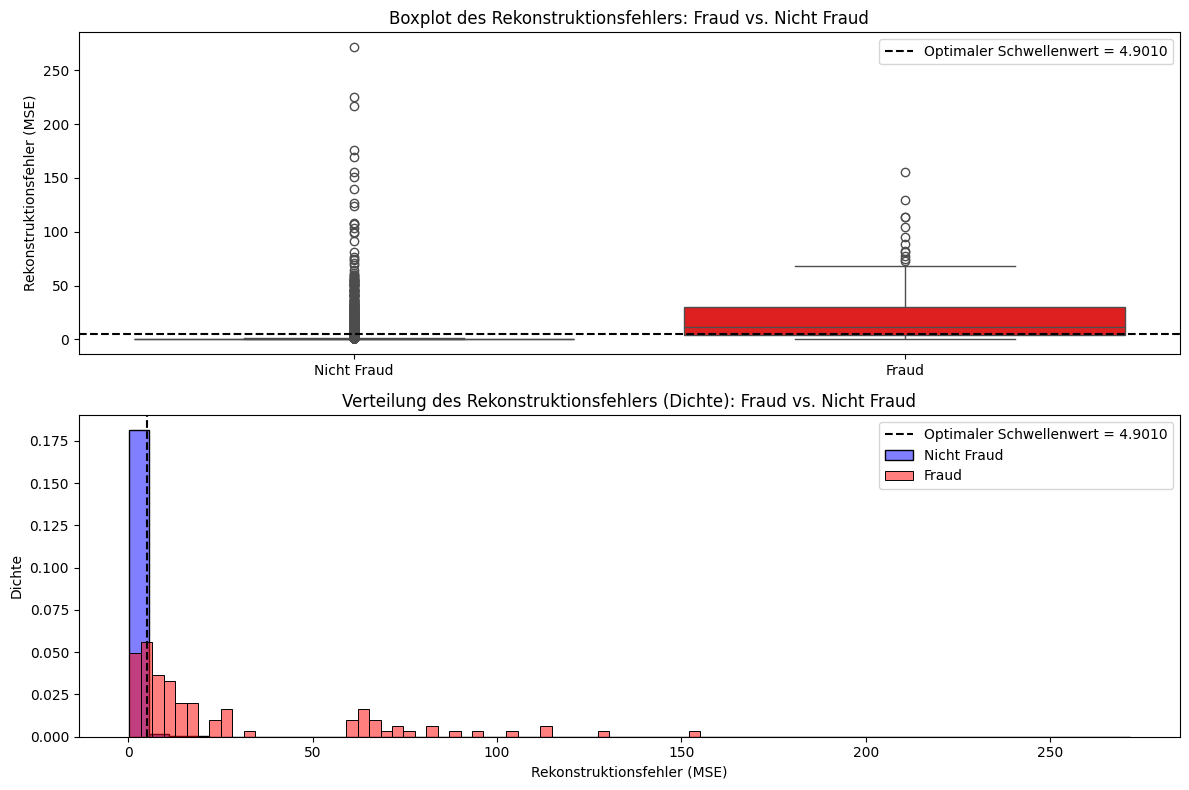

In [127]:
plot_reconstruction_analysis(
    svae,
    X_test,
    np.squeeze(y_test),  # Squeeze y_test, um (n_samples,) zu erhalten
    threshold=optimal_threshold,
    folder_name="vae_results/reconstruction_analysis"
)

##4. Plot AUC ROC

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Classification Performance:
Accuracy: 0.9991
Precision: 0.8182
Recall: 0.6429
F1 Score: 0.7200


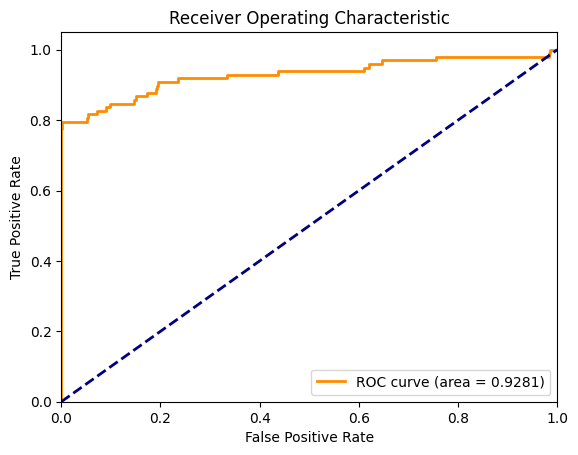

In [137]:
# Evaluate the classifier on test data
_,_,_, y_pred_prob_svae = svae.predict(X_test)
y_pred_svae = (y_pred_prob_svae > 0.5).astype(int)  # Apply threshold at 0.5

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svae)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svae, average='binary')

print(f"Classification Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_svae)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Classifikation report

In [140]:
classification_report_svae = classification_report(y_test, y_pred_svae)
print(classification_report_svae)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56864
         1.0       0.82      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



## 5.Plotten des latenten Raums

Latenter Raum wurde gespeichert unter: /content/drive/MyDrive/svae_results/latent_space/latent_space_SupervisedVAE_20250301_082502.png


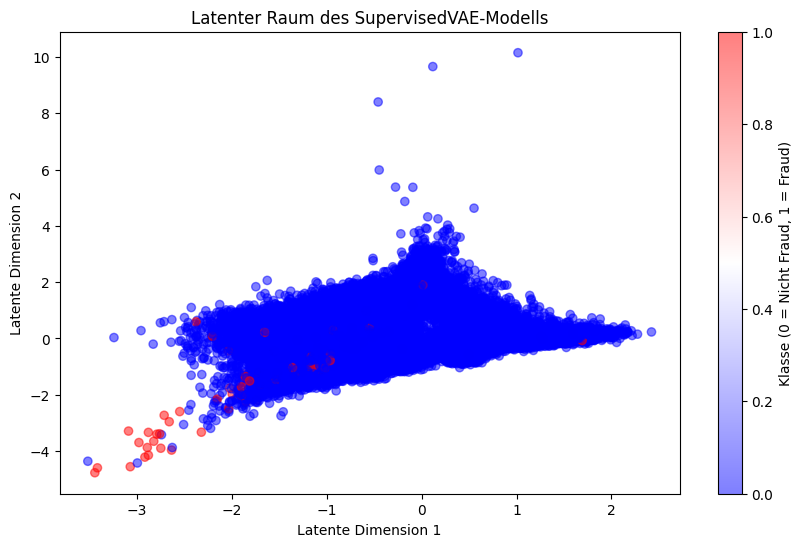

In [141]:
plot_latent_space(
    svae,
    X_test,
    np.squeeze(y_test),  # Squeeze y_test, um (n_samples,) zu erhalten
    folder_name="svae_results/latent_space"
)

_______________________________________________________

---



#V. Threshold-Sensitivitätsanalyse

In [22]:
X = df.drop('Class', axis=1).values
y = df['Class'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Konvertiere zu float32 und forme y zu (batch_size, 1) für Supervised-Modelle
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = np.expand_dims(y_train.astype(np.float32), axis=-1)  # Shape (n_samples, 1) für Supervised
y_test = np.expand_dims(y_test.astype(np.float32), axis=-1)    # Shape (n_samples, 1) für Supervised
y_train_unsupervised = y_train.flatten()  # Eindimensional für Unsupervised (nur normale Daten)
y_test_unsupervised = y_test.flatten()

# Debugging
print("X_train shape:", X_train.shape)
print("y_train shape (Supervised):", y_train.shape, "Unique values:", np.unique(y_train))
print("X_test shape:", X_test.shape)
print("y_test shape (Supervised):", y_test.shape, "Unique values:", np.unique(y_test))

X_train shape: (227845, 29)
y_train shape (Supervised): (227845, 1) Unique values: [0. 1.]
X_test shape: (56962, 29)
y_test shape (Supervised): (56962, 1) Unique values: [0. 1.]


In [161]:
# Modellinstanziierung
models = {
    'UnsupervisedAE': UnsupervisedAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=32,
        activation='mish',
        dropout_rate=0.1
    ),
    'UnsupervisedVAE': UnsupervisedVAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=16,
        activation='mish',
        dropout_rate=0.1,
        kl_weight=1.0
    ),
    'SupervisedAE': SupervisedAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=32,
        classifier_dims=[16],
        activation='mish',
        dropout_rate=0.1
    ),
    'SupervisedVAE': SupervisedVAE(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        latent_dim=16,
        classifier_dims=[16],
        activation='mish',
        dropout_rate=0.1,
        kl_weight=1.0
    )
}

In [171]:
def train_and_plot_model(model_class, model_type, X_train, y_train, X_test, y_test):
    learning_rate = 0.001  # Definieren Sie den Lernrate-Wert
    if model_type in ['uae', 'uvae']:
        # Für unüberwachte Modelle: Nur normale Daten (Class=0) verwenden
        X_train_normal = X_train[y_train.flatten() == 0]
        model = model_class(
            input_dim=X_train.shape[1],
            latent_dim=16,
            hidden_dims=[64, 32],
            activation='mish',
            dropout_rate=0.1
        )
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        history = model.fit(X_train_normal, epochs=5, batch_size=256,validation_split=0.1, verbose=0)
    else:  # 'sae', 'svae'
        model = model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=16,
            classifier_dims=[16],
            activation='mish',
            dropout_rate=0.1
        )
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
        history = model.fit(X_train,y_train, epochs=5, validation_split=0.1, verbose=0)

    # Plotten der Loss-Kurven
    fig, axes = plot_loss_curves(
        history,
        model_type=model_type,
        folder_name="all_results/loss_curves"
    )
    #model.save_model_to_drive()



In [172]:
# Trainieren und plotten für jedes Modell
for model_class, model_type in [
    (UnsupervisedAE, 'uae'),
    (UnsupervisedVAE, 'uvae'),
    (SupervisedAE, 'sae'),
    (SupervisedVAE, 'svae')
]:
    print(f"\nTraining und Plotten für {model_type.upper()}...")
    train_and_plot_model(model_class, model_type, X_train, y_train, X_test, y_test)


Training und Plotten für UAE...
Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_uae_20250301_093813.png

Training und Plotten für UVAE...
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_uvae_20250301_093857.png

Training und Plotten für SAE...
Warnung: 'loss' nicht in history.history gefunden – Gesamtverlust wird nicht geplottet.
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_sae_20250301_094229.png

Training und Plotten für SVAE...
Loss-Kurven wurden gespeichert unter: /content/drive/MyDrive/all_results/loss_curves/loss_curves_svae_20250301_094501.png


In [178]:
for model_name, model in models.items():
    print(f"\nThreshold-Sensitivitätsanalyse für {model_name}...")

    # Berechnung des Rekonstruktionsfehlers
    reconstruction_error = calculate_reconstruction_error(model, X_test)

    # Testen verschiedener Schwellenwerte
    thresholds = np.arange(0.1, 5.0, 0.1)
    f1_scores = []
    precisions = []
    recalls = []

    for threshold in thresholds:
        fraud_predictions = detect_fraud(model, X_test, threshold=threshold)
        metrics = evaluate_fraud_detection(model, X_test, np.squeeze(y_test), threshold=threshold, save_metrics=False)
        f1_scores.append(metrics['F1-Score'])
        precisions.append(metrics['Precision'])
        recalls.append(metrics['Recall'])

    # Visualisierung
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, label='F1-Score', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.title(f"Threshold-Sensitivitätsanalyse für {model_name}")
    plt.xlabel("Schwellenwert")
    plt.ylabel("Metrik")
    plt.legend()
    plt.grid(True)

    # Speichern in Google Drive
    base_dir = "/content/drive/MyDrive"
    folder_path = os.path.join(base_dir, f"vae_results/threshold_sensitivity_{model_name.lower()}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(folder_path, f"threshold_sensitivity_{model_name}_{timestamp}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Threshold-Sensitivitätsplot wurde gespeichert unter: {save_path}")
    best_f1 = max(f1_scores)
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Bester F1-Score: {best_f1:.4f} bei Schwellenwert {best_threshold:.2f}")


Threshold-Sensitivitätsanalyse für UnsupervisedAE...

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       0.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0017
ROC-AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       0.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0017
ROC-AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0018
ROC-AUC: 0.5000

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.02      0.03     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.02     56962
   macro avg       0.50      0.51      0.02     56962
weighted avg       1.00      0.02      0.03     56962


Metriken:
Precision: 0.0018
Recall: 1.0000
F1-Score: 0.0035
Accuracy: 0.0194
ROC-AUC: 0.5089

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0020
ROC-AUC: 0.5001

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.02      0.04     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.02     56962
   macro avg       0.50      0.51      0.02     56962
weighted avg       1.00      0.02      0.04     56962


Metriken:
Precision: 0.0018
Recall: 1.0000
F1-Score: 0.0035
Accuracy: 0.0200
ROC-AUC: 0.5092

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       0.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0017
ROC-AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0018
ROC-AUC: 0.5000

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.02      0.04     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.02     56962
   macro avg       0.50      0.51      0.02     56962
weighted avg       1.00      0.02      0.04     56962


Metriken:
Precision: 0.0018
Recall: 1.0000
F1-Score: 0.0035
Accuracy: 0.0197
ROC-AUC: 0.5090

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       0.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0017
ROC-AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.00      0.00     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.50      0.50      0.00     56962
weighted avg       1.00      0.00      0.00     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0034
Accuracy: 0.0018
ROC-AUC: 0.5000

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00      0.01      0.02     56864
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.01     56962
   macro avg       0.50      0.51      0.01     56962
weighted avg       1.00      0.01      0.02     56962


Metriken:
Precision: 0.0017
Recall: 1.0000
F1-Score: 0.0035
Accuracy: 0.0141
ROC-AUC: 0.5062

Klassifikationsbericht:
              precision    recall  f1-score   support

 Nicht Fraud       1.00     

# VI. Hyperparameter-Tuining

In [23]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00


In [28]:
import optuna
from sklearn.model_selection import StratifiedKFold

## Hilffunktion um Modell zu erstellen

In [25]:
def create_model(model_class, latent_dim, activation, dropout_rate, kl_weight=None, classifier_dims=None):
    if model_class in [UnsupervisedVAE, SupervisedVAE]:
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            activation=activation,
            dropout_rate=dropout_rate,
            kl_weight=kl_weight if kl_weight is not None else 1.0
        )
    elif model_class == SupervisedAE:
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            classifier_dims=classifier_dims,  # Einzelne Schicht für SAE
            activation=activation,
            dropout_rate=dropout_rate
        )
    else:  # UnsupervisedAE
        return model_class(
            input_dim=X_train.shape[1],
            hidden_dims=[64, 32],
            latent_dim=latent_dim,
            activation=activation,
            dropout_rate=dropout_rate
        )

## Optuna-Studien für jedes Modell


In [26]:
# Vorbereitung der Daten für Optuna (reduzierte Untermenge für schnellere Ausführung)
X_train_subset = X_train[:10000]  # Reduziere auf 10,000 Beispiele
y_train_subset_unsupervised = y_train_unsupervised[:10000]  # Für Unsupervised
y_train_subset_supervised = y_train[:10000]  # Für Supervised

In [29]:
# StratifiedKFold für Kreuzvalidierung (5 Folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Daten vorbereitet. Shapes:", X_train.shape, y_train.shape)

Daten vorbereitet. Shapes: (227845, 29) (227845, 1)


In [30]:
# Dictionary zur Speicherung der besten Parameter
best_params_dict = {}

In [31]:
import json # Import the json module
from sklearn.model_selection import StratifiedKFold

In [1]:
best_params_dict = {}

# Optuna-Tuning für jedes Modell mit for-Schleife
for model_class, model_type in [
    (UnsupervisedAE, 'uae'),
    (UnsupervisedVAE, 'uvae'),
    (SupervisedAE, 'sae'),
    (SupervisedVAE, 'svae')
]:
    model_name = model_class.__name__  # Extrahiere den Namen der Klasse (z. B. 'UnsupervisedAE')
    print(f"\nHyperparameter-Tuning mit Optuna für {model_name} (ROC-AUC)...")

    # Definiere Optuna-Studie
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

    # Zielfunktion für alle Modelle
    def objective(trial):
        # Hyperparameter-Suchraum
        latent_dim = trial.suggest_categorical('latent_dim', [2,8,16])
        activation = trial.suggest_categorical('activation', ['relu', 'mish', 'swish'])
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2, step=0.1)

        # Zusätzliche Hyperparameter für VAE-Modelle
        kl_weight = None
        if model_type in ['uvae', 'svae']:
            kl_weight = trial.suggest_float('kl_weight', 0.5, 2.0, step=0.5)

        # Zusätzliche Hyperparameter für Supervised-Modelle
        classifier_dims = None
        if model_type in ['sae', 'svae']:
            classifier_dims = trial.suggest_categorical('classifier_dims', [ 8,16])

        # Erstelle und kompiliere Modell
        model = create_model(model_class, latent_dim, activation, dropout_rate, kl_weight, classifier_dims)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

        # Baue das Modell explizit, bevor wir fit aufrufen
        X_train_normal_subset = X_train_subset[y_train_subset_unsupervised == 0]

        input_shape = (None, X_train.shape[1]) if model_type in ['sae', 'svae'] else (None, X_train_normal_subset.shape[1])
        model.build(input_shape=input_shape) # Baut das Modell mit dem richtigen Shape


        # Reduziere Trainingszeit: Weniger Epochs und kleinere Batch-Größe
        if model_type in ['uae', 'uvae']:
            X_train_normal = X_train_subset[y_train_subset_unsupervised == 0]
            if len(X_train_normal) == 0:
                raise ValueError("Keine normalen Daten (Class=0) gefunden – überprüfen Sie y_train")
            history = model.fit(X_train_normal, epochs=15, batch_size=128, validation_split=0.2, verbose=0)

            # Berechne ROC-AUC basierend auf Rekonstruktionsfehlern
            reconstruction_error = calculate_reconstruction_error(model, X_test)
            roc_auc = roc_auc_score(y_test_unsupervised, reconstruction_error)

        else:  # 'sae', 'svae'
            history = model.fit(X_train_subset,y_train_subset_supervised, epochs=15, validation_split=0.2, verbose=0)

            # Berechne ROC-AUC basierend auf Klassifikation
            predictions = model.predict(tf.convert_to_tensor(X_test, dtype=tf.float32))[-1]
            y_pred = (predictions > 0.5).astype(int)  # Apply threshold at 0.5
            roc_auc = roc_auc_score(np.squeeze(y_test), y_pred)

        return roc_auc

    # Optimiere mit 20 Trials (kurze Laufzeit)
    study.optimize(objective, n_trials=20)

    # Speichere die besten Parameter
    best_params = study.best_params
    best_params_dict[model_name] = best_params
    print(f"Beste Parameter für {model_name}: {best_params}")
    print(f"Bester ROC-AUC: {study.best_value:.4f}")

    # Speichere die besten Parameter in einer JSON-Datei in Google Drive
    base_dir = "/content/drive/MyDrive"
    folder_path = os.path.join(base_dir, "hyperparmetrtuning_results/parameters")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    params_file = os.path.join(folder_path, f"best_params_{model_name.lower()}_{timestamp}.json")
    with open(params_file, 'w') as f:
        json.dump(best_params, f, indent=4)
    print(f"Beste Parameter wurden gespeichert unter: {params_file}")

    # Optional: Evaluieren Sie die besten Parameter ohne Modellspeicherung
    model = create_model(
        model_class,
        best_params['latent_dim'],
        best_params['activation'],
        best_params['dropout_rate'],
        best_params.get('kl_weight', 1.0) if model_type in ['uvae', 'svae'] else None,
        best_params.get('classifier_dims', [16]) if model_type in ['sae', 'svae'] else None
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']))
    model.build(input_shape=(None, X_train.shape[1]))  # Baut das Modell

    if model_type in ['uae', 'uvae']:
        X_train_normal = X_train[y_train_unsupervised == 0]
        history = model.fit(X_train_normal, epochs=50, batch_size=256, validation_split=0.1, verbose=0)
        reconstruction_error = calculate_reconstruction_error(model, X_test)
        roc_auc = roc_auc_score(y_test_unsupervised, reconstruction_error)
    else:
        history = model.fit(X_train,y_train, epochs=50, validation_split=0.1, verbose=0)
        predictions = model.predict(tf.convert_to_tensor(X_test, dtype=tf.float32))[-1]
        roc_auc = roc_auc_score(np.squeeze(y_test), predictions)

    print(f"Validierter ROC-AUC mit besten Parametern für {model_name}: {roc_auc:.4f}")

    # Plotten der Loss-Kurven für die validierten Parameter (ohne Modellspeicherung)
    plot_loss_curves(
        history,
        model_type=model_type,
        folder_name=f"hyperparmetrtuning_results/loss_curves_tuned_roc_auc"
    )

NameError: name 'UnsupervisedAE' is not defined

In [ ]:
# Dictionary zur Speicherung der besten Parameter
best_params_dict = {}

# Optuna-Tuning für jedes Modell mit for-Schleife
for model_class, model_type in [
    (UnsupervisedAE, 'uae'),
    (UnsupervisedVAE, 'uvae'),
    (SupervisedAE, 'sae'),
    (SupervisedVAE, 'svae')
]:
    model_name = model_class.__name__
    print(f"\nHyperparameter-Optimierung mit Optuna für {model_name} (ROC-AUC mit StratifiedKFold)...")

    # Erstelle eine Optuna-Studie
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

    def objective(trial):
        # Hyperparameter-Suchraum (vereinfacht)
        latent_dim = trial.suggest_categorical('latent_dim', [2,8,16])
        activation = trial.suggest_categorical('activation', ['relu', 'mish'])
        learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.2)

        # Zusätzliche Parameter für VAE-Modelle
        kl_weight = None
        if model_type in ['uvae', 'svae']:
            kl_weight = trial.suggest_float('kl_weight', 0.5, 2.0)

        # Zusätzliche Parameter für Supervised-Modelle
        classifier_dim = None
        if model_type in ['sae', 'svae']:
            classifier_dim = trial.suggest_categorical('classifier_dim', [8, 16])

        # Initialisiere ROC-AUC über die Folds
        roc_auc_scores = []

        # StratifiedKFold für robuste Evaluierung
        for train_idx, val_idx in skf.split(X_train, y_train.flatten()):
            X_train_fold = X_train[train_idx]
            y_train_fold = y_train[train_idx]
            X_val_fold = X_train[val_idx]
            y_val_fold = y_train[val_idx]

            # Erstelle und kompiliere das Modell
            model = create_model(model_class, latent_dim, activation, dropout_rate, kl_weight, classifier_dim)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

            # Baue das Modell
            if model_type in ['uae', 'uvae']:
                X_train_normal_fold = X_train_fold[y_train_fold.flatten() == 0]
                if len(X_train_normal_fold) == 0:
                    raise ValueError("Keine normalen Daten gefunden!")
                model.build(input_shape=(None, X_train_normal_fold.shape[1]))
                history = model.fit(X_train_normal_fold, epochs=5, batch_size=64, validation_data=(X_val_fold[y_val_fold.flatten() == 0], None), verbose=0)
                # Berechne Rekonstruktionsfehler für Validierungsdaten
                recon_error = calculate_reconstruction_error(model, X_val_fold)
                if np.any(np.isnan(recon_error)):
                    recon_error = np.nan_to_num(recon_error, nan=np.mean(recon_error))
                roc_auc = roc_auc_score(y_val_fold.flatten(), recon_error)
            else:  # 'sae', 'svae'
                model.build(input_shape=(None, X_train_fold.shape[1]))
                history = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=64, validation_data=(X_val_fold, y_val_fold), verbose=0)
                # Berechne Klassifikations-ROC-AUC
                preds = model.classify(tf.convert_to_tensor(X_val_fold, dtype=tf.float32)).numpy()
                roc_auc = roc_auc_score(y_val_fold.flatten(), preds)

            roc_auc_scores.append(roc_auc)

        # Rückgabe des durchschnittlichen ROC-AUC über alle Folds
        mean_roc_auc = np.mean(roc_auc_scores)
        return mean_roc_auc

    # Führe 20 Trials durch
    study.optimize(objective, n_trials=4)

    # Speichere die besten Parameter
    best_params = study.best_params
    best_params_dict[model_name] = best_params
    print(f"Beste Parameter für {model_name}: {best_params}")
    print(f"Bester durchschnittlicher ROC-AUC (5-Fold): {study.best_value:.4f}")

    # Visualisiere wichtige Hyperparameter
    import optuna.visualization as ov
    fig = ov.plot_param_importances(study, target_name="ROC-AUC")
    base_dir = "/content/drive/MyDrive"
    folder_path = os.path.join(base_dir, f"hyperparmetrtuning_results/param_importances_{model_name}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(folder_path, f"param_importances_{model_name}_{timestamp}.png")
    fig.write_image(save_path, format='png', width=800, height=600)
    print(f"Wichtige Hyperparameter wurden visualisiert und gespeichert unter: {save_path}")

    # Speichere die besten Parameter in einer JSON-Datei
    params_folder = os.path.join(base_dir, "hyperparmetrtuning_results/parameters")
    if not os.path.exists(params_folder):
        os.makedirs(params_folder)
    params_file = os.path.join(params_folder, f"best_params_{model_name.lower()}_{timestamp}.json")
    with open(params_file, 'w') as f:
        json.dump({"params": best_params, "roc_auc": study.best_value}, f, indent=2)
    print(f"Beste Parameter wurden gespeichert unter: {params_file}")

[I 2025-03-01 19:58:24,615] A new study created in memory with name: no-name-b6b937f4-1901-463c-bf0e-ce0ffcb868ff



Hyperparameter-Optimierung mit Optuna für UnsupervisedAE (ROC-AUC mit StratifiedKFold)...
